In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import os
from datetime import datetime

In [61]:
# Config
TOLERANCIA_SINCRONIZACAO_S = 0.5     # Tolerância máxima (em seg) para juntar sensores
FREQ_DOWNSAMPLE = '1s'          # '1min' = 1 ponto por minuto. Tente '10s' para 10 segundos.
N_CLUSTERS = 3          # Número de clusters desejados
PESSOA_INICIAL = 38      # Escolher a pessoa (exemplo)
WINDOW_SIZE = 7           # Número de pontos por janela (tamanho da janela). Usar este valor para window_size em funções

In [62]:
def carregar_dados_pessoa(pessoa_id):
    # Caminhos dos arquivos
    accel_file = f'acelerometro/acelerometro_{pessoa_id}.csv'
    
    gyro_file = f'giroscopio/giroscopio_{pessoa_id}.csv'
    
    # Carregar acelerômetro (CSV com cabeçalho)
    df_accel = pd.read_csv(accel_file)
    df_accel['timestamp'] = pd.to_datetime(df_accel['timestamp'])
    
    # Carregar giroscópio (TXT sem cabeçalho)
    df_gyro = pd.read_csv(gyro_file)
    df_gyro['timestamp'] = pd.to_datetime(df_gyro['timestamp'])
    
    return df_accel, df_gyro

In [63]:
df_accel, df_gyro = carregar_dados_pessoa(38)
print(df_gyro)

                       timestamp         x         y         z
0     2025-06-26 15:27:02.079341 -0.003665 -0.003665  0.000000
1     2025-06-26 15:27:10.430394 -0.004887 -0.002443  0.002443
2     2025-06-26 15:27:18.781448  0.000000  0.002443  0.000000
3     2025-06-26 15:27:27.132501  0.003665  0.000000 -0.001222
4     2025-06-26 15:27:35.483555  0.006109  0.000000  0.000000
...                          ...       ...       ...       ...
10342 2025-06-27 15:26:28.675126 -0.008552  0.020769  0.001222
10343 2025-06-27 15:26:37.026180  0.030543  0.035430  0.036652
10344 2025-06-27 15:26:45.377233  0.160047  0.037874 -0.032987
10345 2025-06-27 15:26:53.728287  0.018326  0.065973  0.023213
10346 2025-06-27 15:27:02.079341 -0.125838 -0.064752 -0.067195

[10347 rows x 4 columns]


In [64]:
def sincronizar_dados(df_accel, df_gyro, TOLERANCIA_SINCRONIZACAO_S=None):
    """
    Sincroniza dados de acelerômetro e giroscópio baseado em timestamps
    e cria janelas de tempo com múltiplos pontos

    Args:
        TOLERANCIA_SINCRONIZACAO_S: (opcional) taxa de amostragem em segundos. Usada para ajustar a tolerância do merge_asof.

    Returns:
        DataFrame: Dados sincronizados e agrupados
    """
    # Merge dos dados usando o timestamp mais próximo
    df_accel = df_accel.sort_values('timestamp').reset_index(drop=True)
    df_gyro = df_gyro.sort_values('timestamp').reset_index(drop=True)

    # Determinar tolerância baseada na taxa de amostragem (se fornecida) ou usar 0.1s por padrão
    if TOLERANCIA_SINCRONIZACAO_S is not None:
        tol = pd.Timedelta(seconds=TOLERANCIA_SINCRONIZACAO_S)
    else:
        tol = pd.Timedelta(seconds=0.1)

    # Combinar timestamps próximos
    df_combined = pd.merge_asof(
        df_accel, 
        df_gyro, 
        on='timestamp', 
        direction='nearest',
        tolerance=tol,
        suffixes=('', '_gyro')
    )
    
    # Renomear colunas do giroscópio para gx, gy, gz
    df_combined = df_combined.rename(columns={
        'x_gyro': 'gx',
        'y_gyro': 'gy',
        'z_gyro': 'gz'
    })
    
    df_combined = df_combined.dropna()
    
    return df_combined


In [65]:
print(dados_sincronizados := sincronizar_dados(df_accel, df_gyro))

                       timestamp         x         y         z        gx  \
0     2025-06-26 15:27:02.079341  2.300828  9.493010 -2.128445 -0.003665   
1     2025-06-26 15:27:10.430394  2.458845  9.361329 -2.178724 -0.004887   
2     2025-06-26 15:27:18.781448  2.427721  9.358934 -2.202666  0.000000   
3     2025-06-26 15:27:27.132501  2.559402  9.550470 -2.092532  0.003665   
4     2025-06-26 15:27:35.483555  2.446874  9.660604 -2.195483  0.006109   
...                          ...       ...       ...       ...       ...   
10342 2025-06-27 15:26:28.675126 -3.155558 -6.488286  6.191406 -0.008552   
10343 2025-06-27 15:26:37.026180 -3.404555 -6.473921  6.196194  0.030543   
10344 2025-06-27 15:26:45.377233 -3.617639 -6.126762  5.743690  0.160047   
10345 2025-06-27 15:26:53.728287 -3.593697 -5.753267  7.381324  0.018326   
10346 2025-06-27 15:27:02.079341 -3.313575 -5.743690  7.295133 -0.125838   

             gy        gz  
0     -0.003665  0.000000  
1     -0.002443  0.002443  
2  

In [66]:
# # 'dados_sincronizados' é o seu DataFrame da célula 6
# print(f"Pontos originais: {len(dados_sincronizados)}")

# # 1. Definir o timestamp como o índice
# df_indexado = dados_sincronizados.set_index('timestamp')

# # 2. Fazer o Downsample (Reamostragem)
# # '1S' = agrupar dados em janelas de 1 segundo
# # .mean() = calcular a média de todas as 7 leituras dentro daquele segundo
# df_downsampled = df_indexado.resample('1T').mean()

# # 3. Limpar linhas que possam ter ficado vazias (se houver buracos nos dados)
# df_downsampled = df_downsampled.dropna()

# # 4. (Opcional) Voltar o timestamp para uma coluna, se sua função 'criar_janelas'
# #    não esperar que ele seja o índice.
# df_downsampled = df_downsampled.reset_index()

# print(f"Pontos após downsample para 1Hz: {len(df_downsampled)}")

# # AGORA, você usaria 'df_downsampled' na sua função 'criar_features_janela'

In [67]:
def criar_features_janela(df_downsampled, window_size):
    """
    Cria features agrupando múltiplos pontos consecutivos em uma janela
    
    Args:
        df: DataFrame com dados sincronizados
        window_size: Número de pontos por janela (cluster point)
    
    Returns:
        numpy array: Features para clustering (cada linha = 1 janela com múltiplos pontos)
    """
    features_list = []
    
    # Percorrer os dados em janelas
    for i in range(0, len(df_downsampled) - window_size + 1, window_size):
        window = df_downsampled.iloc[i:i+window_size]
        
        # Concatenar todos os valores da janela em um único vetor de features
        feature_vector = []
        for _, row in window.iterrows():
            # Adicionar acelerômetro (x, y, z)
            feature_vector.extend([row['x'], row['y'], row['z']])
            # Adicionar giroscópio (gx, gy, gz)
            feature_vector.extend([row['gx'], row['gy'], row['gz']])
        
        features_list.append(feature_vector)
    
    return np.array(features_list)

In [68]:
features_lista = criar_features_janela(dados_sincronizados, WINDOW_SIZE)
tam = len(features_lista[0])
print(tam)
print(len(features_lista))

42
1478


In [69]:
def aplicar_kmeans(features, n_clusters):
    """
    Aplica K-means clustering nas features
    
    Args:
        features: Array de features
        n_clusters: Número de clusters
    
    Returns:
        tuple: (modelo KMeans treinado, labels dos clusters, features normalizadas)
    """
    # Normalizar features
    scaler = StandardScaler()
    features_normalized = scaler.fit_transform(features)
    
    # Aplicar K-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(features_normalized)
    
    return kmeans, labels, features_normalized

In [70]:
def plotar_resultados(labels, pessoa_id, window_size):
    """
    Plota os resultados do clustering
    
    Args:
        labels: Labels preditos pelo K-means
        pessoa_id: ID da pessoa
        window_size: Tamanho da janela usada
    """
    plt.figure(figsize=(14, 6))
    
    # Criar eixo X (índice do conjunto de pontos)
    x = np.arange(len(labels))
    
    # Identificar clusters únicos
    unique, counts = np.unique(labels, return_counts=True)
    n_clusters = len(unique)
    
    # Paleta de cores dinâmica
    color_palette = plt.cm.tab10(np.linspace(0, 1, n_clusters))
    color_map = {cluster_id: color_palette[i] for i, cluster_id in enumerate(unique)}
    
    # Plot 1: Labels ao longo do tempo
    plt.subplot(1, 2, 1)
    colors = [color_map[label] for label in labels]
    plt.scatter(x, labels, c=colors, alpha=0.6, s=50)
    plt.xlabel('Índice do Conjunto de Pontos', fontsize=12)
    plt.ylabel('Cluster (Label Predito)', fontsize=12)
    plt.title(f'K-means Clustering - Pessoa {pessoa_id}\n(Cada ponto = {window_size} leituras)', fontsize=14)
    plt.yticks(unique, [f'Cluster {i}' for i in unique])
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Distribuição dos clusters
    plt.subplot(1, 2, 2)
    cluster_labels = [f'Cluster {i}' for i in unique]
    plt.bar(cluster_labels, counts, color=color_palette, alpha=0.7)
    plt.xlabel('Cluster', fontsize=12)
    plt.ylabel('Número de Conjuntos de Pontos', fontsize=12)
    plt.title('Distribuição dos Clusters', fontsize=14)
    plt.grid(True, alpha=0.3, axis='y')
    
    # Adicionar valores nas barras
    for i, count in enumerate(counts):
        plt.text(i, count, str(count), ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(f'clustering_pessoa_{pessoa_id}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ Gráfico salvo como 'clustering_pessoa_{pessoa_id}.png'")


In [71]:
def analisar_pessoa(pessoa_id, window_size, n_clusters):
    """
    Análise completa de clusterização para uma pessoa
    """
    print(f"\n{'='*60}")
    print(f"ANÁLISE - PESSOA {pessoa_id}")
    print(f"{'='*60}")

    # 1. Carregar dados
    print("\n[1/6] Carregando dados...")
    df_accel, df_gyro = carregar_dados_pessoa(pessoa_id)
    print(f"   ✓ Acelerômetro: {len(df_accel)} pontos")
    print(f"   ✓ Giroscópio: {len(df_gyro)} pontos")

    # 2. Sincronizar dados
    print("\n[2/6] Sincronizando dados (tolerância={TOLERANCIA_SINCRONIZACAO_S}s)...")
    df_combined = sincronizar_dados(df_accel, df_gyro, TOLERANCIA_SINCRONIZACAO_S)
    print(f"   ✓ Dados sincronizados: {len(df_combined)} pontos (taxa original)")

    # 3. Usar dados sincronizados (downsample tratado em outra função)
    print("\n[3/6] Usando dados sincronizados (sem chamar realizar_downsample)...")
    df_final = df_combined
    print(f"   ✓ Pontos usados: {len(df_final)} pontos")

    # 4. Criar features em janelas
    print(f"\n[4/6] Criando features (janelas de {window_size} pontos)...")
    features = criar_features_janela(df_final, window_size)
    n_features_per_window = window_size * 6
    print(f"   ✓ {len(features)} conjuntos de pontos criados")
    print(f"   ✓ Cada conjunto representa {window_size} * {FREQ_DOWNSAMPLE}")

    # 5. Aplicar K-means
    print(f"\n[5/6] Aplicando K-means (k={n_clusters})...")
    kmeans, labels, features_normalized = aplicar_kmeans(features, n_clusters)
    print(f"   ✓ Clustering concluído")
    print(f"   ✓ Inércia: {kmeans.inertia_:.2f}")

    # 6. Plotar resultados
    print("\n[6/6] Gerando visualização...")
    plotar_resultados(labels, pessoa_id, window_size)

    # Estatísticas
    print(f"\n{'='*60}")
    print("ESTATÍSTICAS")
    print(f"{'='*60}")
    unique, counts = np.unique(labels, return_counts=True)
    for cluster_id, count in zip(unique, counts):
        percentage = (count / len(labels)) * 100
        print(f"Cluster {cluster_id}: {count} conjuntos ({percentage:.1f}%)")

    return df_combined, features, labels, kmeans

In [72]:
# Validação rápida: verifica que a criação de features respeita WINDOW_SIZE
# Executar após definir/rodar analisar_pessoa para validar comportamento
try:
    # Se as variáveis ainda não existirem no escopo, pedimos para executar as células anteriores primeiro
    assert 'dados_sincronizados' in globals() or 'df_combined' in globals(), \
        "Execute as células de carregamento/sincronização antes desta validação."

    # Obter df usado: prefer df_combined criado pela última análise ou dados_sincronizados
    df_to_use = globals().get('df_combined', globals().get('dados_sincronizados'))

    # Gerar features de teste com WINDOW_SIZE
    test_features = criar_features_janela(df_to_use, WINDOW_SIZE)

    assert len(test_features) > 0, "Nenhuma janela criada — verifique WINDOW_SIZE e o tamanho do dataframe."
    assert len(test_features[0]) == WINDOW_SIZE * 6, \
        f"Cada feature deve ter WINDOW_SIZE*6 elementos, esperado {WINDOW_SIZE*6}, obteve {len(test_features[0])}."

    print(f"✓ Validação: {len(test_features)} janelas criadas; cada janela tem {len(test_features[0])} features ({WINDOW_SIZE} pontos × 6).")
except AssertionError as ae:
    print(f"✗ Validação falhou: {ae}")
except Exception as e:
    print(f"✗ Erro na validação: {e}")

✓ Validação: 1478 janelas criadas; cada janela tem 42 features (7 pontos × 6).


In [73]:
def analisar_todas_pessoas(window_size, n_clusters):
    """
    Análise de clusterização para todas as pessoas
    
    Args:
        window_size: Número de pontos por janela
        n_clusters: Número de clusters
    """
    # IDs das pessoas disponíveis
    pessoas = [11, 12, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 
               29, 30, 31, 32, 33, 34, 36, 37, 38]
    
    resultados = {}
    
    print("\n" + "="*60)
    print("ANÁLISE DE TODAS AS PESSOAS")
    print("="*60)
    
    for pessoa_id in pessoas:
        try:
            df_combined, features, labels, kmeans = analisar_pessoa(
                pessoa_id, window_size, n_clusters
            )
            resultados[pessoa_id] = {
                'data': df_combined,
                'features': features,
                'labels': labels,
                'kmeans': kmeans
            }
        except Exception as e:
            print(f"\n⚠ Erro ao processar pessoa {pessoa_id}: {e}")
            continue
    
    # Sumário geral
    print(f"\n\n{'='*60}")
    print("SUMÁRIO GERAL")
    print(f"{'='*60}")
    print(f"Total de pessoas analisadas: {len(resultados)}/{len(pessoas)}")
    
    return resultados


CLUSTERIZAÇÃO K-MEANS - ACELERÔMETRO E GIROSCÓPIO
Taxa de amostragem: 0.5s
Número de clusters: 3
Tamanho da janela: 7 pontos (leituras por janela)

------------------------------------------------------------
Opção escolhida: Analisar uma pessoa primeiro
------------------------------------------------------------

ANÁLISE - PESSOA 38

[1/6] Carregando dados...
   ✓ Acelerômetro: 10347 pontos
   ✓ Giroscópio: 10347 pontos

[2/6] Sincronizando dados (tolerância={TOLERANCIA_SINCRONIZACAO_S}s)...
   ✓ Dados sincronizados: 10347 pontos (taxa original)

[3/6] Usando dados sincronizados (sem chamar realizar_downsample)...
   ✓ Pontos usados: 10347 pontos

[4/6] Criando features (janelas de 7 pontos)...
   ✓ 1478 conjuntos de pontos criados
   ✓ Cada conjunto representa 7 * 1s

[5/6] Aplicando K-means (k=3)...
   ✓ Clustering concluído
   ✓ Inércia: 47990.78

[6/6] Gerando visualização...
   ✓ 1478 conjuntos de pontos criados
   ✓ Cada conjunto representa 7 * 1s

[5/6] Aplicando K-means (k=3

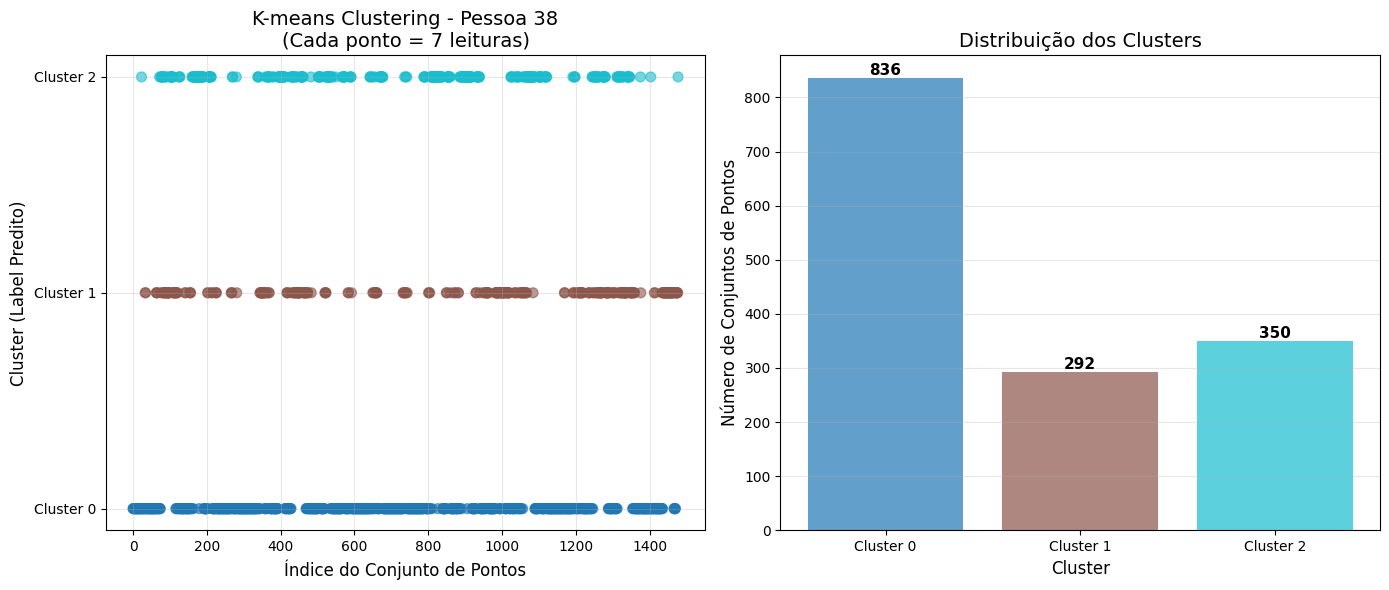


✓ Gráfico salvo como 'clustering_pessoa_38.png'

ESTATÍSTICAS
Cluster 0: 836 conjuntos (56.6%)
Cluster 1: 292 conjuntos (19.8%)
Cluster 2: 350 conjuntos (23.7%)

ANÁLISE DE TODAS AS PESSOAS

ANÁLISE - PESSOA 11

[1/6] Carregando dados...
   ✓ Acelerômetro: 9711 pontos
   ✓ Giroscópio: 9711 pontos

[2/6] Sincronizando dados (tolerância={TOLERANCIA_SINCRONIZACAO_S}s)...
   ✓ Dados sincronizados: 9711 pontos (taxa original)

[3/6] Usando dados sincronizados (sem chamar realizar_downsample)...
   ✓ Pontos usados: 9711 pontos

[4/6] Criando features (janelas de 7 pontos)...
   ✓ 1387 conjuntos de pontos criados
   ✓ Cada conjunto representa 7 * 1s

[5/6] Aplicando K-means (k=3)...
   ✓ Clustering concluído
   ✓ Inércia: 46356.84

[6/6] Gerando visualização...
   ✓ 1387 conjuntos de pontos criados
   ✓ Cada conjunto representa 7 * 1s

[5/6] Aplicando K-means (k=3)...
   ✓ Clustering concluído
   ✓ Inércia: 46356.84

[6/6] Gerando visualização...


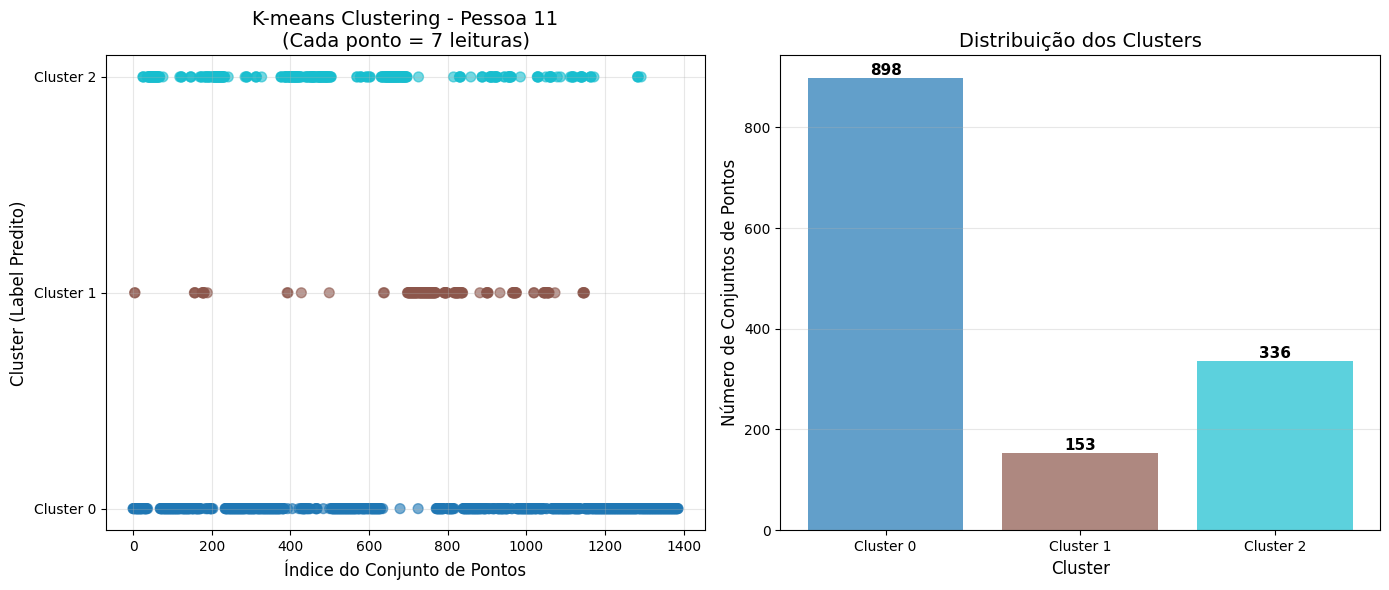


✓ Gráfico salvo como 'clustering_pessoa_11.png'

ESTATÍSTICAS
Cluster 0: 898 conjuntos (64.7%)
Cluster 1: 153 conjuntos (11.0%)
Cluster 2: 336 conjuntos (24.2%)

ANÁLISE - PESSOA 12

[1/6] Carregando dados...
   ✓ Acelerômetro: 8209 pontos
   ✓ Giroscópio: 8209 pontos

[2/6] Sincronizando dados (tolerância={TOLERANCIA_SINCRONIZACAO_S}s)...
   ✓ Dados sincronizados: 8209 pontos (taxa original)

[3/6] Usando dados sincronizados (sem chamar realizar_downsample)...
   ✓ Pontos usados: 8209 pontos

[4/6] Criando features (janelas de 7 pontos)...
   ✓ 1172 conjuntos de pontos criados
   ✓ Cada conjunto representa 7 * 1s

[5/6] Aplicando K-means (k=3)...
   ✓ Clustering concluído
   ✓ Inércia: 39885.22

[6/6] Gerando visualização...
   ✓ 1172 conjuntos de pontos criados
   ✓ Cada conjunto representa 7 * 1s

[5/6] Aplicando K-means (k=3)...
   ✓ Clustering concluído
   ✓ Inércia: 39885.22

[6/6] Gerando visualização...


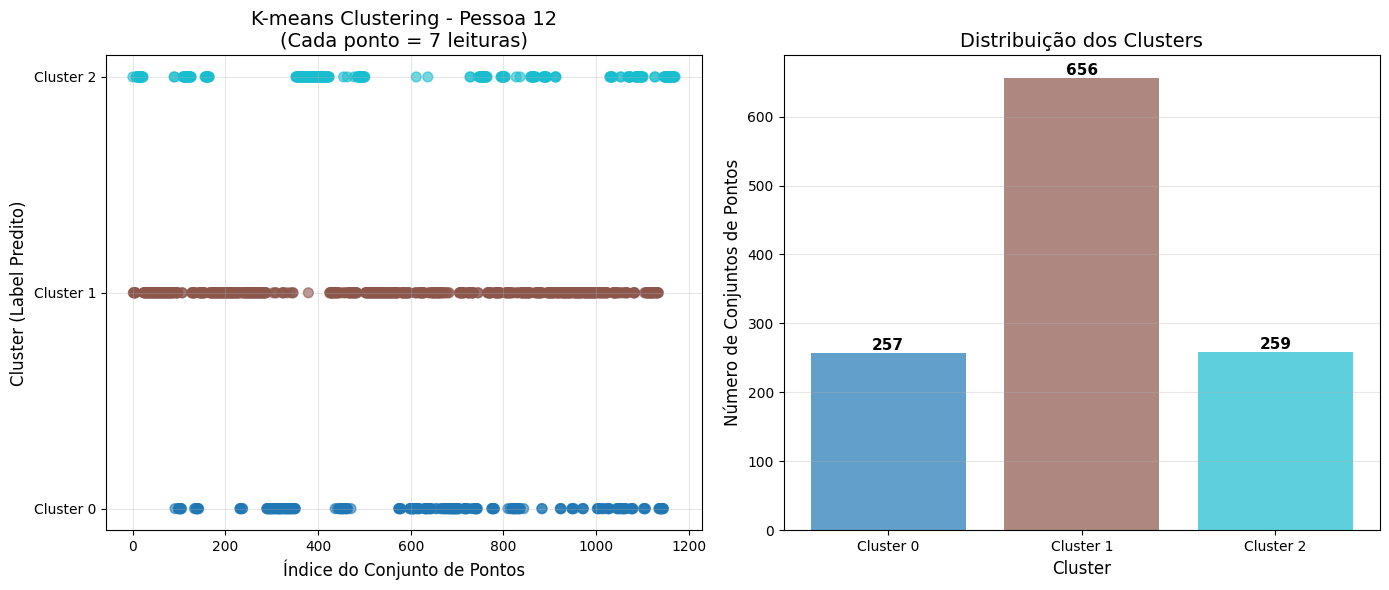


✓ Gráfico salvo como 'clustering_pessoa_12.png'

ESTATÍSTICAS
Cluster 0: 257 conjuntos (21.9%)
Cluster 1: 656 conjuntos (56.0%)
Cluster 2: 259 conjuntos (22.1%)

ANÁLISE - PESSOA 12

[1/6] Carregando dados...
   ✓ Acelerômetro: 8209 pontos
   ✓ Giroscópio: 8209 pontos

[2/6] Sincronizando dados (tolerância={TOLERANCIA_SINCRONIZACAO_S}s)...
   ✓ Dados sincronizados: 8209 pontos (taxa original)

[3/6] Usando dados sincronizados (sem chamar realizar_downsample)...
   ✓ Pontos usados: 8209 pontos

[4/6] Criando features (janelas de 7 pontos)...
   ✓ 1172 conjuntos de pontos criados
   ✓ Cada conjunto representa 7 * 1s

[5/6] Aplicando K-means (k=3)...
   ✓ Clustering concluído
   ✓ Inércia: 39885.22

[6/6] Gerando visualização...
   ✓ 1172 conjuntos de pontos criados
   ✓ Cada conjunto representa 7 * 1s

[5/6] Aplicando K-means (k=3)...
   ✓ Clustering concluído
   ✓ Inércia: 39885.22

[6/6] Gerando visualização...


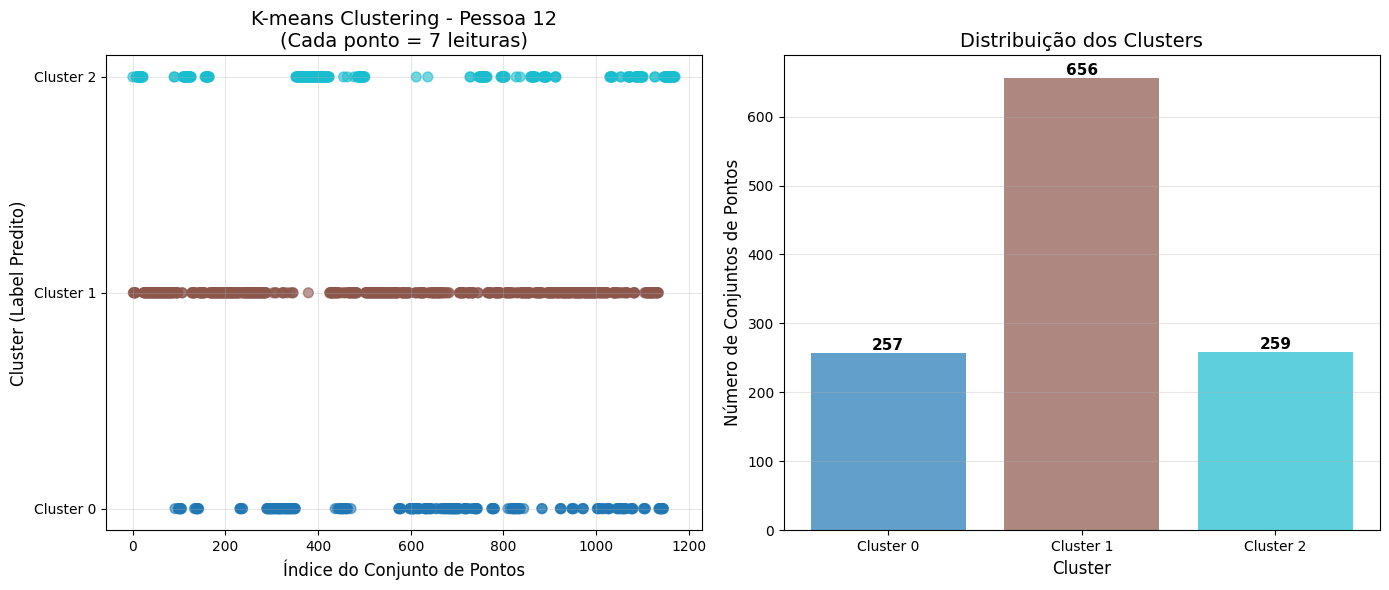


✓ Gráfico salvo como 'clustering_pessoa_12.png'

ESTATÍSTICAS
Cluster 0: 257 conjuntos (21.9%)
Cluster 1: 656 conjuntos (56.0%)
Cluster 2: 259 conjuntos (22.1%)

ANÁLISE - PESSOA 14

[1/6] Carregando dados...
   ✓ Acelerômetro: 8504 pontos
   ✓ Giroscópio: 8504 pontos

[2/6] Sincronizando dados (tolerância={TOLERANCIA_SINCRONIZACAO_S}s)...
   ✓ Dados sincronizados: 8504 pontos (taxa original)

[3/6] Usando dados sincronizados (sem chamar realizar_downsample)...
   ✓ Pontos usados: 8504 pontos

[4/6] Criando features (janelas de 7 pontos)...
   ✓ 1214 conjuntos de pontos criados
   ✓ Cada conjunto representa 7 * 1s

[5/6] Aplicando K-means (k=3)...
   ✓ Clustering concluído
   ✓ Inércia: 38705.27

[6/6] Gerando visualização...
   ✓ 1214 conjuntos de pontos criados
   ✓ Cada conjunto representa 7 * 1s

[5/6] Aplicando K-means (k=3)...
   ✓ Clustering concluído
   ✓ Inércia: 38705.27

[6/6] Gerando visualização...


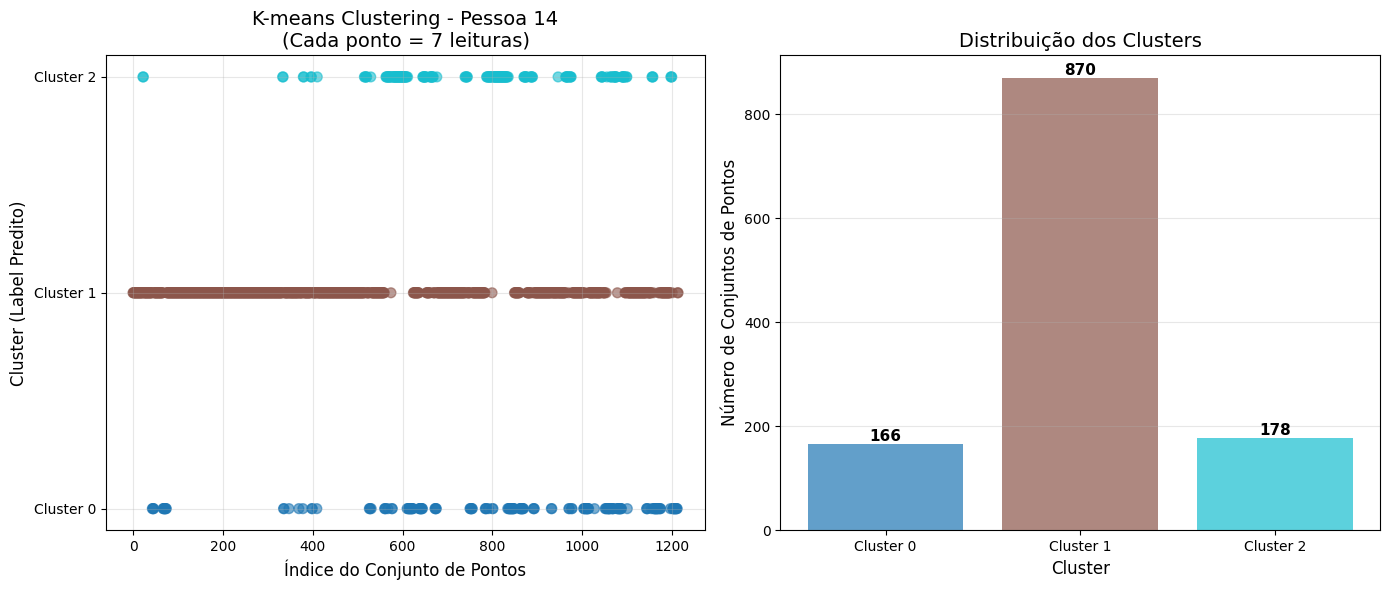


✓ Gráfico salvo como 'clustering_pessoa_14.png'

ESTATÍSTICAS
Cluster 0: 166 conjuntos (13.7%)
Cluster 1: 870 conjuntos (71.7%)
Cluster 2: 178 conjuntos (14.7%)

ANÁLISE - PESSOA 15

[1/6] Carregando dados...
   ✓ Acelerômetro: 7143 pontos
   ✓ Giroscópio: 2740 pontos

[2/6] Sincronizando dados (tolerância={TOLERANCIA_SINCRONIZACAO_S}s)...
   ✓ Dados sincronizados: 7143 pontos (taxa original)

[3/6] Usando dados sincronizados (sem chamar realizar_downsample)...
   ✓ Pontos usados: 7143 pontos

[4/6] Criando features (janelas de 7 pontos)...
   ✓ 1020 conjuntos de pontos criados
   ✓ Cada conjunto representa 7 * 1s

[5/6] Aplicando K-means (k=3)...
   ✓ Clustering concluído
   ✓ Inércia: 30045.96

[6/6] Gerando visualização...
   ✓ 1020 conjuntos de pontos criados
   ✓ Cada conjunto representa 7 * 1s

[5/6] Aplicando K-means (k=3)...
   ✓ Clustering concluído
   ✓ Inércia: 30045.96

[6/6] Gerando visualização...


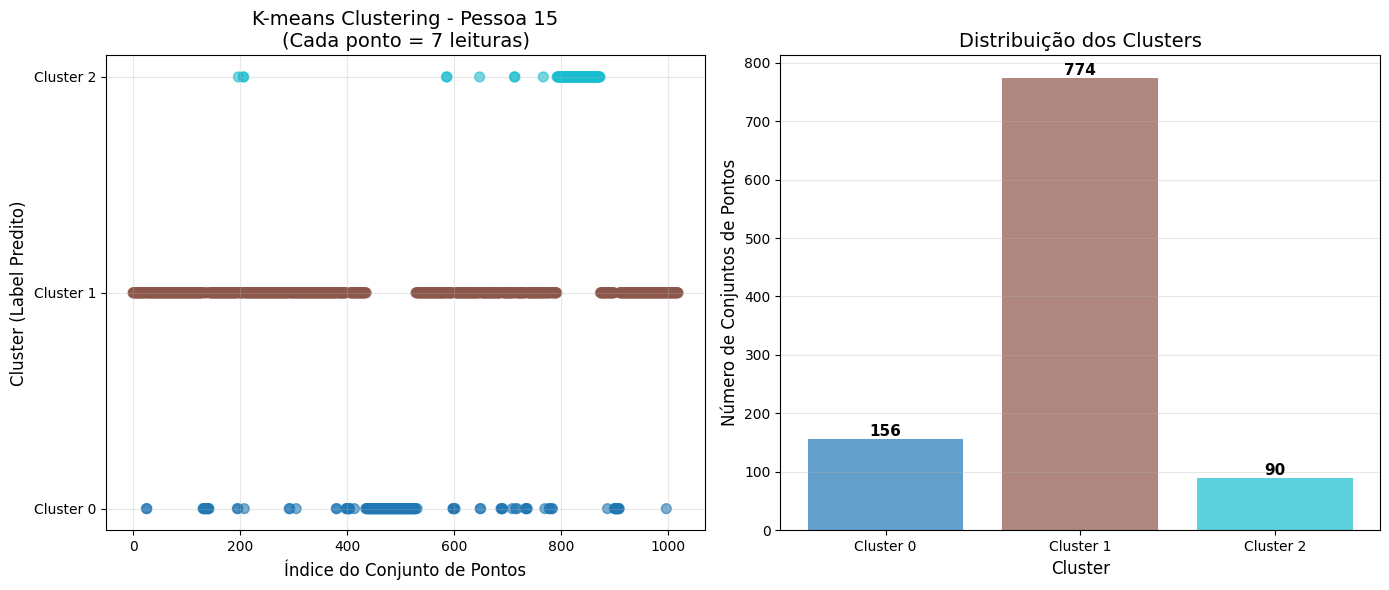


✓ Gráfico salvo como 'clustering_pessoa_15.png'

ESTATÍSTICAS
Cluster 0: 156 conjuntos (15.3%)
Cluster 1: 774 conjuntos (75.9%)
Cluster 2: 90 conjuntos (8.8%)

ANÁLISE - PESSOA 16

[1/6] Carregando dados...
   ✓ Acelerômetro: 9864 pontos
   ✓ Giroscópio: 9864 pontos

[2/6] Sincronizando dados (tolerância={TOLERANCIA_SINCRONIZACAO_S}s)...
   ✓ Dados sincronizados: 9864 pontos (taxa original)

[3/6] Usando dados sincronizados (sem chamar realizar_downsample)...
   ✓ Pontos usados: 9864 pontos

[4/6] Criando features (janelas de 7 pontos)...
   ✓ 1409 conjuntos de pontos criados
   ✓ Cada conjunto representa 7 * 1s

[5/6] Aplicando K-means (k=3)...
   ✓ Clustering concluído
   ✓ Inércia: 46089.51

[6/6] Gerando visualização...
   ✓ 1409 conjuntos de pontos criados
   ✓ Cada conjunto representa 7 * 1s

[5/6] Aplicando K-means (k=3)...
   ✓ Clustering concluído
   ✓ Inércia: 46089.51

[6/6] Gerando visualização...


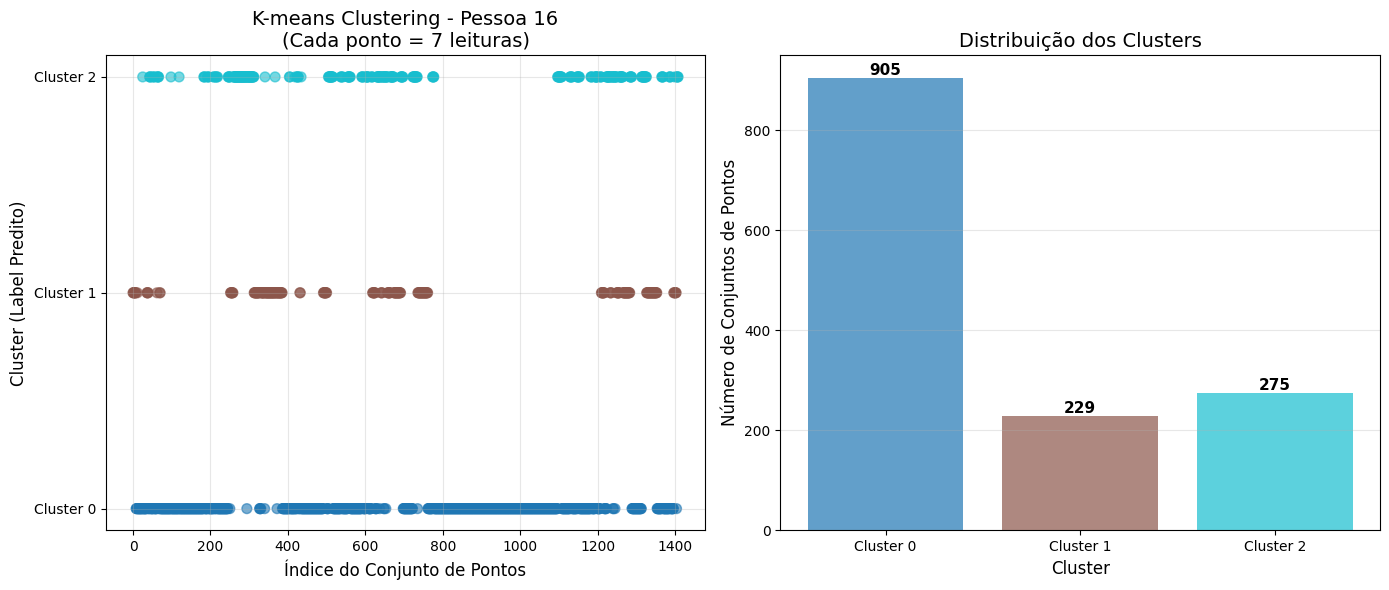


✓ Gráfico salvo como 'clustering_pessoa_16.png'

ESTATÍSTICAS
Cluster 0: 905 conjuntos (64.2%)
Cluster 1: 229 conjuntos (16.3%)
Cluster 2: 275 conjuntos (19.5%)

ANÁLISE - PESSOA 17

[1/6] Carregando dados...
   ✓ Acelerômetro: 7449 pontos
   ✓ Giroscópio: 7449 pontos

[2/6] Sincronizando dados (tolerância={TOLERANCIA_SINCRONIZACAO_S}s)...
   ✓ Dados sincronizados: 7449 pontos (taxa original)

[3/6] Usando dados sincronizados (sem chamar realizar_downsample)...
   ✓ Pontos usados: 7449 pontos

[4/6] Criando features (janelas de 7 pontos)...
   ✓ 1064 conjuntos de pontos criados
   ✓ Cada conjunto representa 7 * 1s

[5/6] Aplicando K-means (k=3)...
   ✓ Clustering concluído
   ✓ Inércia: 36023.61

[6/6] Gerando visualização...
   ✓ 1064 conjuntos de pontos criados
   ✓ Cada conjunto representa 7 * 1s

[5/6] Aplicando K-means (k=3)...
   ✓ Clustering concluído
   ✓ Inércia: 36023.61

[6/6] Gerando visualização...


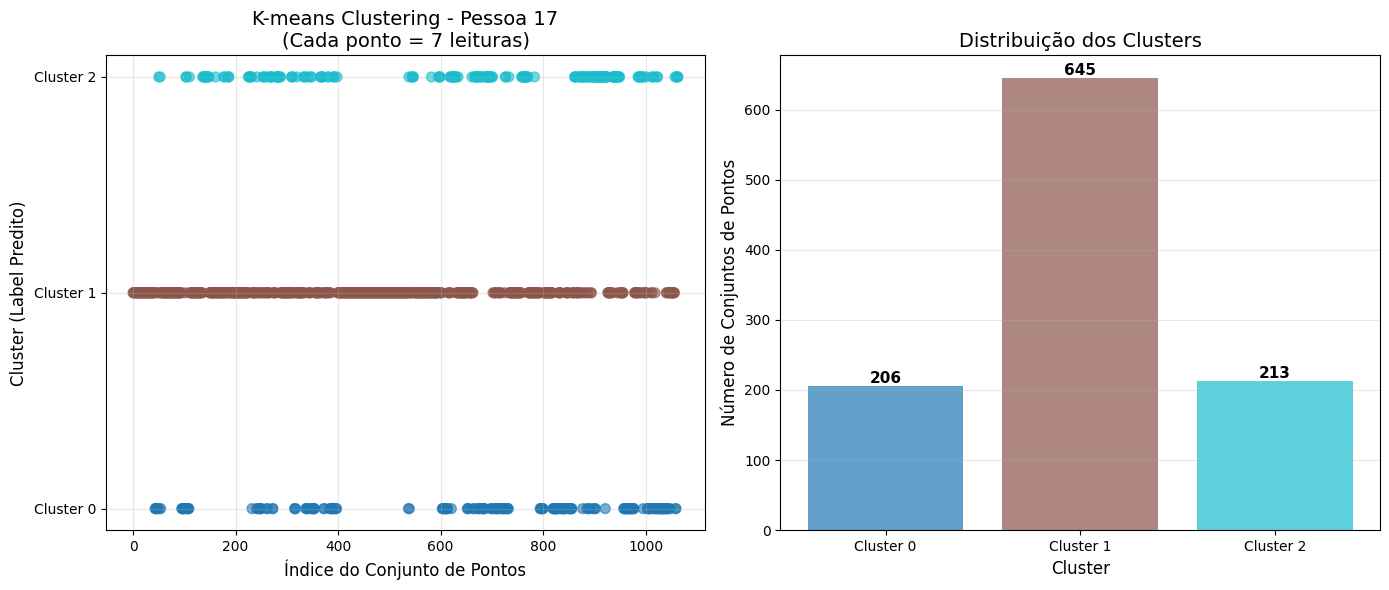


✓ Gráfico salvo como 'clustering_pessoa_17.png'

ESTATÍSTICAS
Cluster 0: 206 conjuntos (19.4%)
Cluster 1: 645 conjuntos (60.6%)
Cluster 2: 213 conjuntos (20.0%)

ANÁLISE - PESSOA 18

[1/6] Carregando dados...
   ✓ Acelerômetro: 7359 pontos
   ✓ Giroscópio: 7359 pontos

[2/6] Sincronizando dados (tolerância={TOLERANCIA_SINCRONIZACAO_S}s)...
   ✓ Dados sincronizados: 7359 pontos (taxa original)

[3/6] Usando dados sincronizados (sem chamar realizar_downsample)...
   ✓ Pontos usados: 7359 pontos

[4/6] Criando features (janelas de 7 pontos)...
   ✓ 1051 conjuntos de pontos criados
   ✓ Cada conjunto representa 7 * 1s

[5/6] Aplicando K-means (k=3)...
   ✓ Clustering concluído
   ✓ Inércia: 34233.33

[6/6] Gerando visualização...
   ✓ 1051 conjuntos de pontos criados
   ✓ Cada conjunto representa 7 * 1s

[5/6] Aplicando K-means (k=3)...
   ✓ Clustering concluído
   ✓ Inércia: 34233.33

[6/6] Gerando visualização...


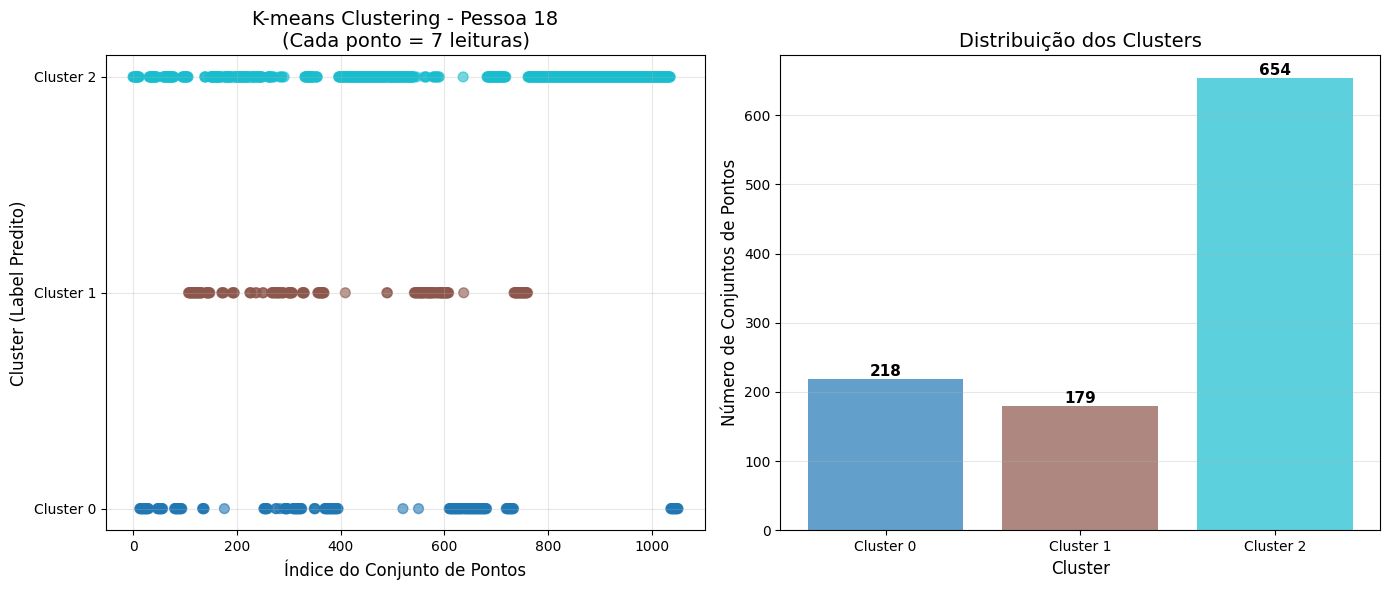


✓ Gráfico salvo como 'clustering_pessoa_18.png'

ESTATÍSTICAS
Cluster 0: 218 conjuntos (20.7%)
Cluster 1: 179 conjuntos (17.0%)
Cluster 2: 654 conjuntos (62.2%)

ANÁLISE - PESSOA 19

[1/6] Carregando dados...
   ✓ Acelerômetro: 9729 pontos
   ✓ Giroscópio: 9729 pontos

[2/6] Sincronizando dados (tolerância={TOLERANCIA_SINCRONIZACAO_S}s)...
   ✓ Dados sincronizados: 9729 pontos (taxa original)

[3/6] Usando dados sincronizados (sem chamar realizar_downsample)...
   ✓ Pontos usados: 9729 pontos

[4/6] Criando features (janelas de 7 pontos)...
   ✓ 1389 conjuntos de pontos criados
   ✓ Cada conjunto representa 7 * 1s

[5/6] Aplicando K-means (k=3)...
   ✓ Clustering concluído
   ✓ Inércia: 44384.80

[6/6] Gerando visualização...
   ✓ 1389 conjuntos de pontos criados
   ✓ Cada conjunto representa 7 * 1s

[5/6] Aplicando K-means (k=3)...
   ✓ Clustering concluído
   ✓ Inércia: 44384.80

[6/6] Gerando visualização...


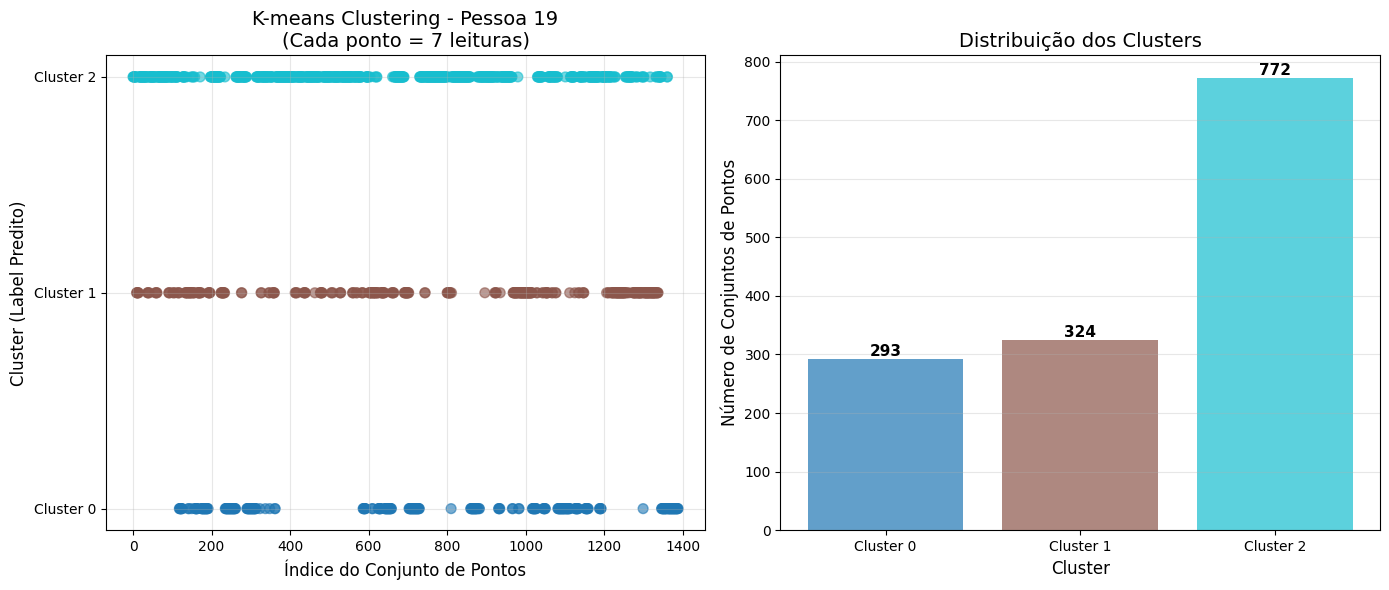


✓ Gráfico salvo como 'clustering_pessoa_19.png'

ESTATÍSTICAS
Cluster 0: 293 conjuntos (21.1%)
Cluster 1: 324 conjuntos (23.3%)
Cluster 2: 772 conjuntos (55.6%)

ANÁLISE - PESSOA 20

[1/6] Carregando dados...
   ✓ Acelerômetro: 9106 pontos
   ✓ Giroscópio: 9106 pontos

[2/6] Sincronizando dados (tolerância={TOLERANCIA_SINCRONIZACAO_S}s)...
   ✓ Dados sincronizados: 9106 pontos (taxa original)

[3/6] Usando dados sincronizados (sem chamar realizar_downsample)...
   ✓ Pontos usados: 9106 pontos

[4/6] Criando features (janelas de 7 pontos)...
   ✓ 1300 conjuntos de pontos criados
   ✓ Cada conjunto representa 7 * 1s

[5/6] Aplicando K-means (k=3)...
   ✓ Clustering concluído
   ✓ Inércia: 42653.24

[6/6] Gerando visualização...
   ✓ 1300 conjuntos de pontos criados
   ✓ Cada conjunto representa 7 * 1s

[5/6] Aplicando K-means (k=3)...
   ✓ Clustering concluído
   ✓ Inércia: 42653.24

[6/6] Gerando visualização...


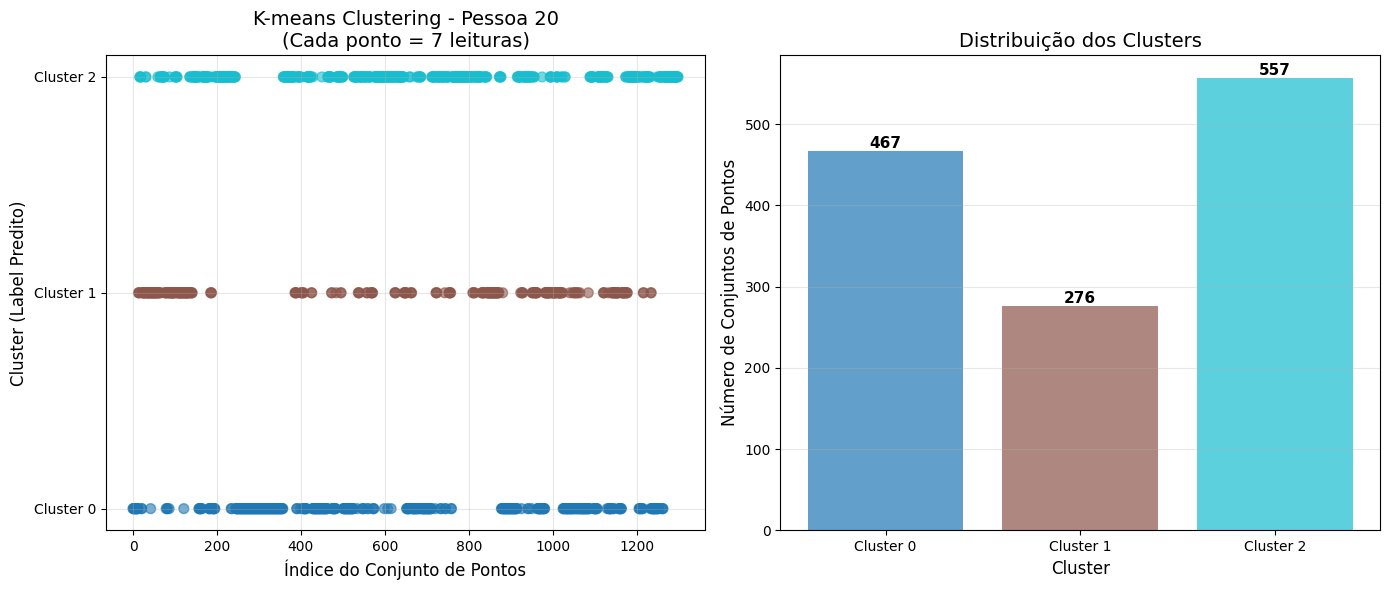


✓ Gráfico salvo como 'clustering_pessoa_20.png'

ESTATÍSTICAS
Cluster 0: 467 conjuntos (35.9%)
Cluster 1: 276 conjuntos (21.2%)
Cluster 2: 557 conjuntos (42.8%)

ANÁLISE - PESSOA 21

[1/6] Carregando dados...
   ✓ Acelerômetro: 7605 pontos
   ✓ Giroscópio: 7605 pontos

[2/6] Sincronizando dados (tolerância={TOLERANCIA_SINCRONIZACAO_S}s)...
   ✓ Dados sincronizados: 7605 pontos (taxa original)

[3/6] Usando dados sincronizados (sem chamar realizar_downsample)...
   ✓ Pontos usados: 7605 pontos

[4/6] Criando features (janelas de 7 pontos)...
   ✓ 1086 conjuntos de pontos criados
   ✓ Cada conjunto representa 7 * 1s

[5/6] Aplicando K-means (k=3)...
   ✓ Clustering concluído
   ✓ Inércia: 36300.94

[6/6] Gerando visualização...
   ✓ 1086 conjuntos de pontos criados
   ✓ Cada conjunto representa 7 * 1s

[5/6] Aplicando K-means (k=3)...
   ✓ Clustering concluído
   ✓ Inércia: 36300.94

[6/6] Gerando visualização...


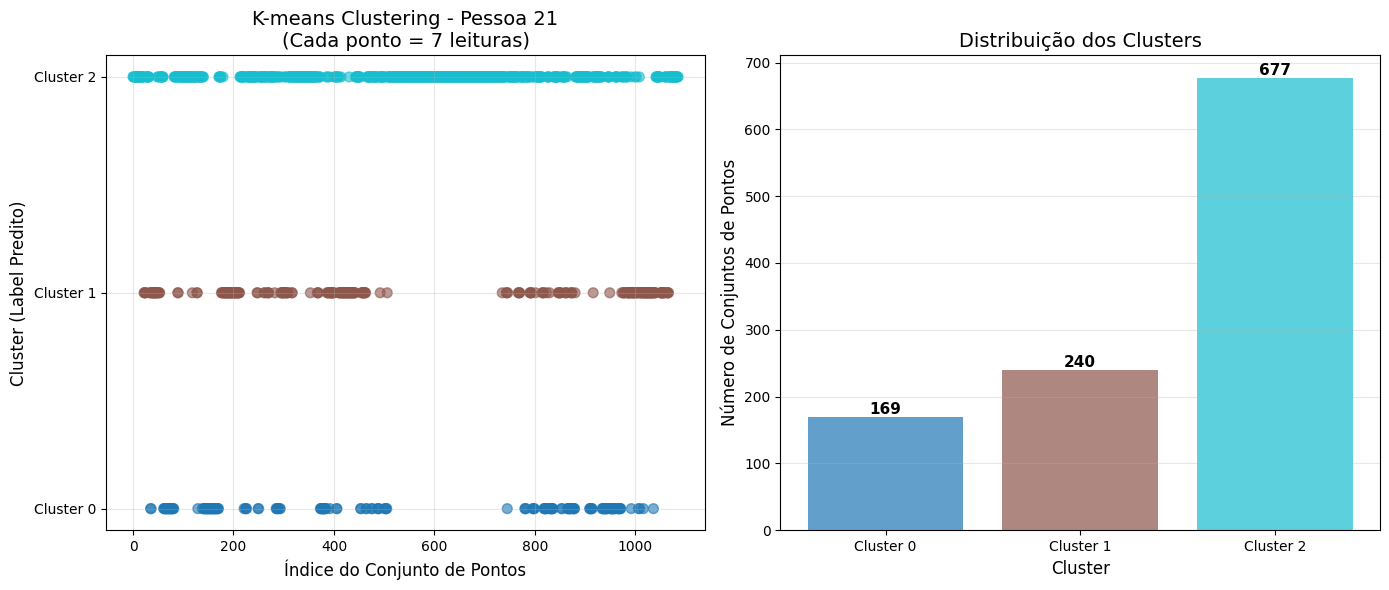


✓ Gráfico salvo como 'clustering_pessoa_21.png'

ESTATÍSTICAS
Cluster 0: 169 conjuntos (15.6%)
Cluster 1: 240 conjuntos (22.1%)
Cluster 2: 677 conjuntos (62.3%)

ANÁLISE - PESSOA 22

[1/6] Carregando dados...
   ✓ Acelerômetro: 8335 pontos
   ✓ Giroscópio: 8335 pontos

[2/6] Sincronizando dados (tolerância={TOLERANCIA_SINCRONIZACAO_S}s)...
   ✓ Dados sincronizados: 8335 pontos (taxa original)

[3/6] Usando dados sincronizados (sem chamar realizar_downsample)...
   ✓ Pontos usados: 8335 pontos

[4/6] Criando features (janelas de 7 pontos)...
   ✓ 1190 conjuntos de pontos criados
   ✓ Cada conjunto representa 7 * 1s

[5/6] Aplicando K-means (k=3)...
   ✓ Clustering concluído
   ✓ Inércia: 38730.75

[6/6] Gerando visualização...
   ✓ 1190 conjuntos de pontos criados
   ✓ Cada conjunto representa 7 * 1s

[5/6] Aplicando K-means (k=3)...
   ✓ Clustering concluído
   ✓ Inércia: 38730.75

[6/6] Gerando visualização...


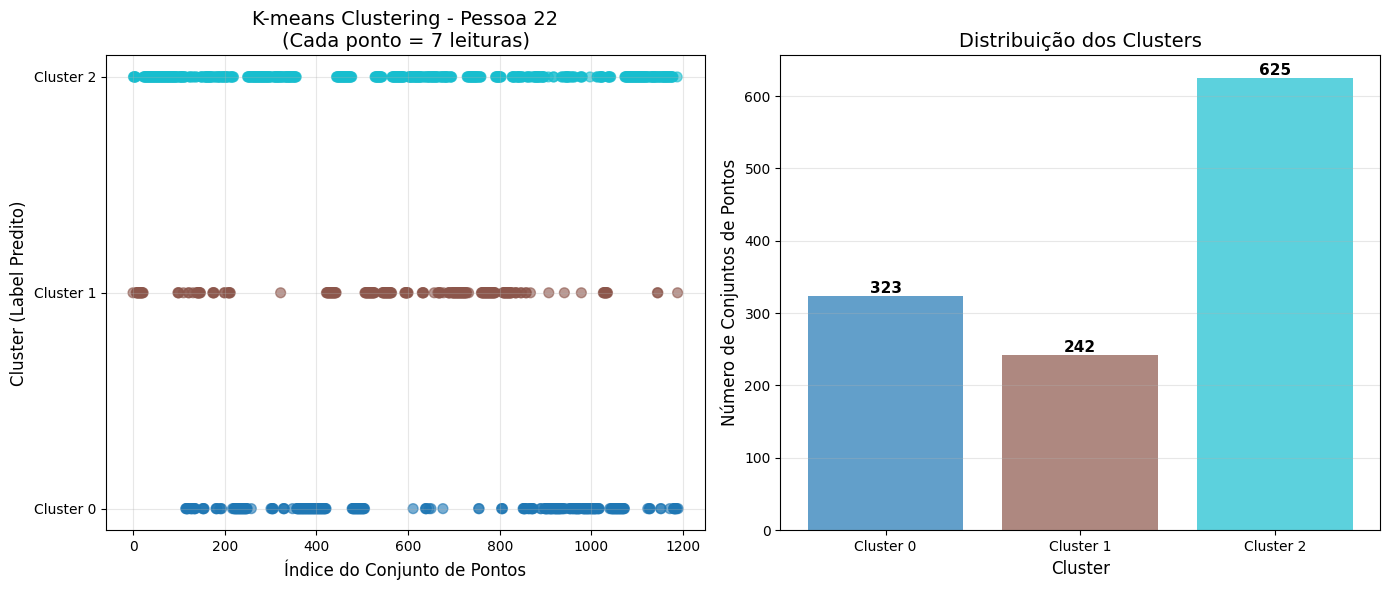


✓ Gráfico salvo como 'clustering_pessoa_22.png'

ESTATÍSTICAS
Cluster 0: 323 conjuntos (27.1%)
Cluster 1: 242 conjuntos (20.3%)
Cluster 2: 625 conjuntos (52.5%)

ANÁLISE - PESSOA 23

[1/6] Carregando dados...
   ✓ Acelerômetro: 9375 pontos
   ✓ Giroscópio: 9375 pontos

[2/6] Sincronizando dados (tolerância={TOLERANCIA_SINCRONIZACAO_S}s)...
   ✓ Dados sincronizados: 9375 pontos (taxa original)

[3/6] Usando dados sincronizados (sem chamar realizar_downsample)...
   ✓ Pontos usados: 9375 pontos

[4/6] Criando features (janelas de 7 pontos)...
   ✓ 1339 conjuntos de pontos criados
   ✓ Cada conjunto representa 7 * 1s

[5/6] Aplicando K-means (k=3)...
   ✓ Clustering concluído
   ✓ Inércia: 44330.72

[6/6] Gerando visualização...
   ✓ 1339 conjuntos de pontos criados
   ✓ Cada conjunto representa 7 * 1s

[5/6] Aplicando K-means (k=3)...
   ✓ Clustering concluído
   ✓ Inércia: 44330.72

[6/6] Gerando visualização...


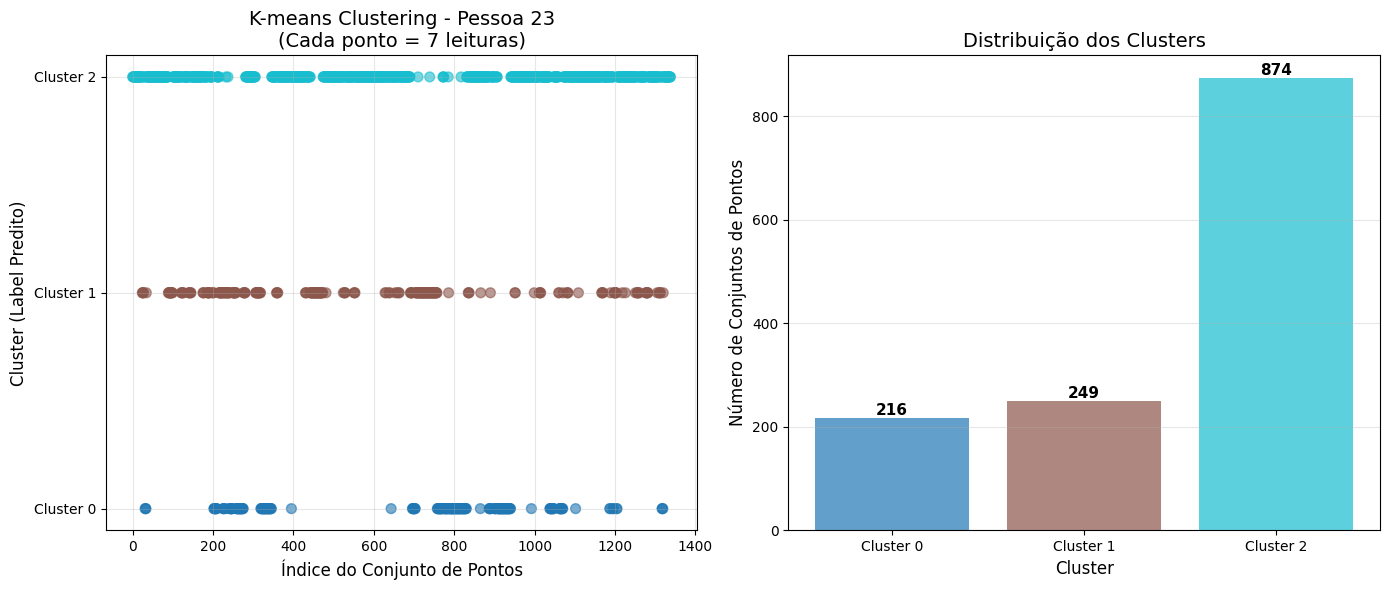


✓ Gráfico salvo como 'clustering_pessoa_23.png'

ESTATÍSTICAS
Cluster 0: 216 conjuntos (16.1%)
Cluster 1: 249 conjuntos (18.6%)
Cluster 2: 874 conjuntos (65.3%)

ANÁLISE - PESSOA 24

[1/6] Carregando dados...
   ✓ Acelerômetro: 7179 pontos
   ✓ Giroscópio: 7179 pontos

[2/6] Sincronizando dados (tolerância={TOLERANCIA_SINCRONIZACAO_S}s)...
   ✓ Dados sincronizados: 7179 pontos (taxa original)

[3/6] Usando dados sincronizados (sem chamar realizar_downsample)...
   ✓ Pontos usados: 7179 pontos

[4/6] Criando features (janelas de 7 pontos)...
   ✓ 1025 conjuntos de pontos criados
   ✓ Cada conjunto representa 7 * 1s

[5/6] Aplicando K-means (k=3)...
   ✓ Clustering concluído
   ✓ Inércia: 34667.53

[6/6] Gerando visualização...
   ✓ 1025 conjuntos de pontos criados
   ✓ Cada conjunto representa 7 * 1s

[5/6] Aplicando K-means (k=3)...
   ✓ Clustering concluído
   ✓ Inércia: 34667.53

[6/6] Gerando visualização...


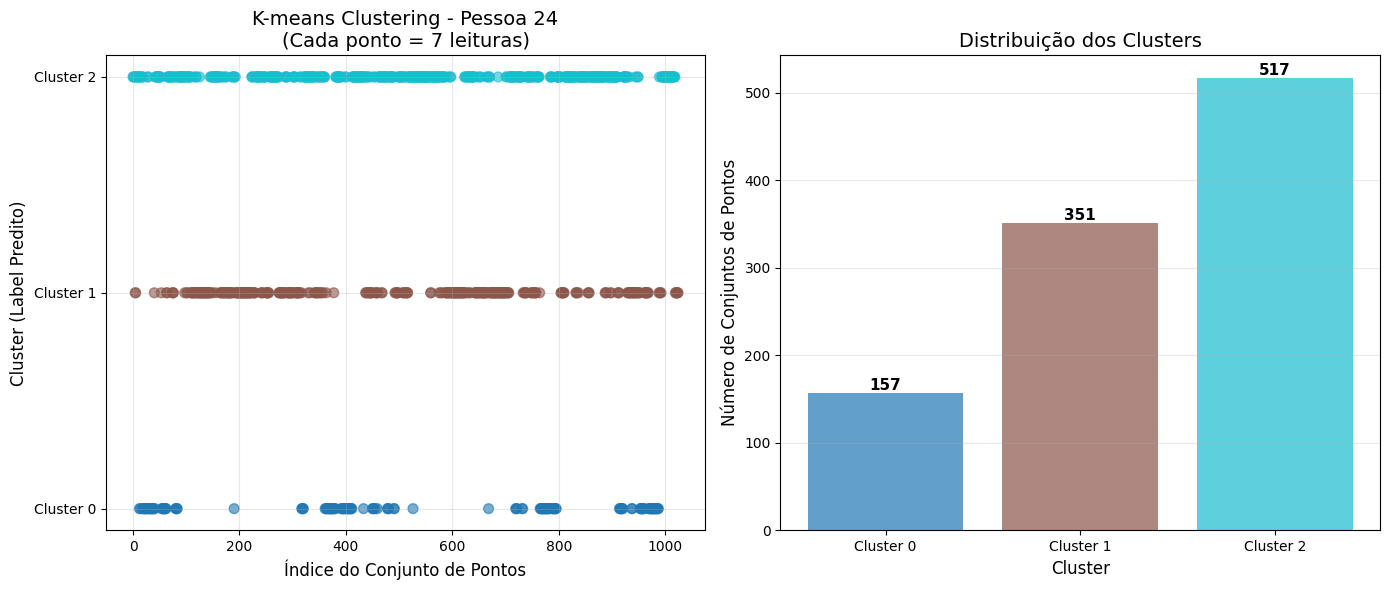


✓ Gráfico salvo como 'clustering_pessoa_24.png'

ESTATÍSTICAS
Cluster 0: 157 conjuntos (15.3%)
Cluster 1: 351 conjuntos (34.2%)
Cluster 2: 517 conjuntos (50.4%)

ANÁLISE - PESSOA 25

[1/6] Carregando dados...
   ✓ Acelerômetro: 8602 pontos
   ✓ Giroscópio: 8602 pontos

[2/6] Sincronizando dados (tolerância={TOLERANCIA_SINCRONIZACAO_S}s)...
   ✓ Dados sincronizados: 8602 pontos (taxa original)

[3/6] Usando dados sincronizados (sem chamar realizar_downsample)...
   ✓ Pontos usados: 8602 pontos

[4/6] Criando features (janelas de 7 pontos)...
   ✓ 1228 conjuntos de pontos criados
   ✓ Cada conjunto representa 7 * 1s

[5/6] Aplicando K-means (k=3)...
   ✓ Clustering concluído
   ✓ Inércia: 40004.67

[6/6] Gerando visualização...
   ✓ 1228 conjuntos de pontos criados
   ✓ Cada conjunto representa 7 * 1s

[5/6] Aplicando K-means (k=3)...
   ✓ Clustering concluído
   ✓ Inércia: 40004.67

[6/6] Gerando visualização...


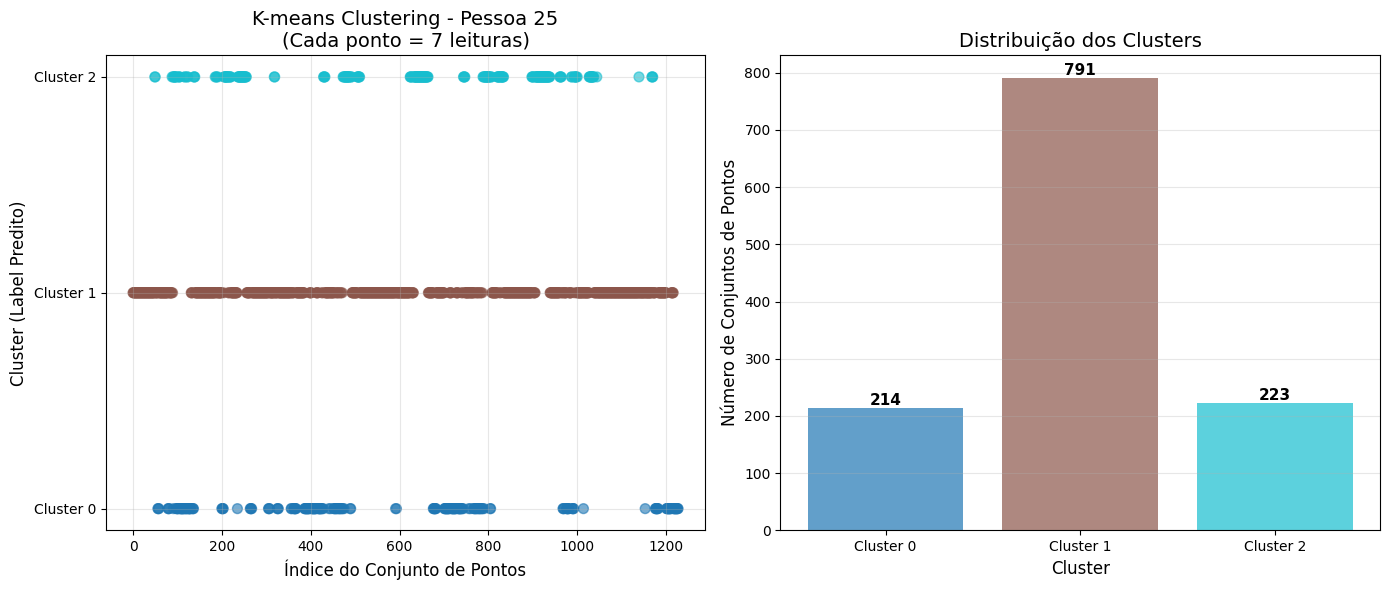


✓ Gráfico salvo como 'clustering_pessoa_25.png'

ESTATÍSTICAS
Cluster 0: 214 conjuntos (17.4%)
Cluster 1: 791 conjuntos (64.4%)
Cluster 2: 223 conjuntos (18.2%)

ANÁLISE - PESSOA 26

[1/6] Carregando dados...
   ✓ Acelerômetro: 8864 pontos
   ✓ Giroscópio: 8864 pontos

[2/6] Sincronizando dados (tolerância={TOLERANCIA_SINCRONIZACAO_S}s)...
   ✓ Dados sincronizados: 8864 pontos (taxa original)

[3/6] Usando dados sincronizados (sem chamar realizar_downsample)...
   ✓ Pontos usados: 8864 pontos

[4/6] Criando features (janelas de 7 pontos)...
   ✓ 1266 conjuntos de pontos criados
   ✓ Cada conjunto representa 7 * 1s

[5/6] Aplicando K-means (k=3)...
   ✓ Clustering concluído
   ✓ Inércia: 42146.93

[6/6] Gerando visualização...
   ✓ 1266 conjuntos de pontos criados
   ✓ Cada conjunto representa 7 * 1s

[5/6] Aplicando K-means (k=3)...
   ✓ Clustering concluído
   ✓ Inércia: 42146.93

[6/6] Gerando visualização...


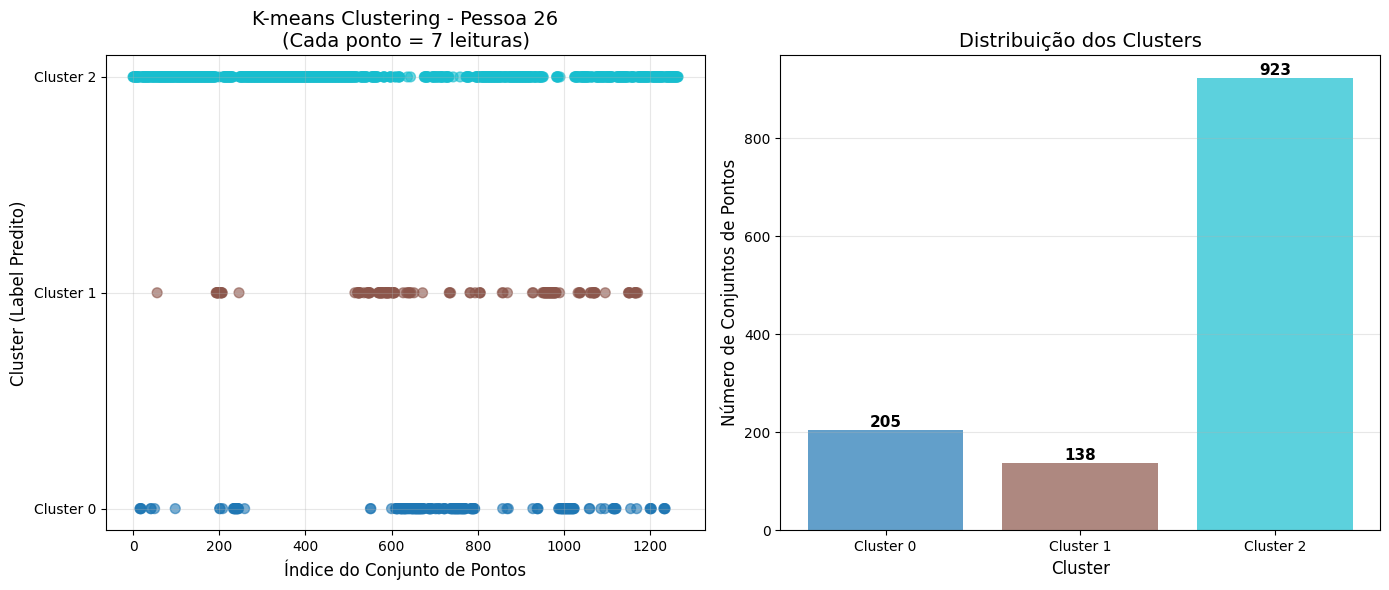


✓ Gráfico salvo como 'clustering_pessoa_26.png'

ESTATÍSTICAS
Cluster 0: 205 conjuntos (16.2%)
Cluster 1: 138 conjuntos (10.9%)
Cluster 2: 923 conjuntos (72.9%)

ANÁLISE - PESSOA 27

[1/6] Carregando dados...
   ✓ Acelerômetro: 8926 pontos
   ✓ Giroscópio: 8926 pontos

[2/6] Sincronizando dados (tolerância={TOLERANCIA_SINCRONIZACAO_S}s)...
   ✓ Dados sincronizados: 8926 pontos (taxa original)

[3/6] Usando dados sincronizados (sem chamar realizar_downsample)...
   ✓ Pontos usados: 8926 pontos

[4/6] Criando features (janelas de 7 pontos)...
   ✓ 1275 conjuntos de pontos criados
   ✓ Cada conjunto representa 7 * 1s

[5/6] Aplicando K-means (k=3)...
   ✓ Clustering concluído
   ✓ Inércia: 43086.18

[6/6] Gerando visualização...
   ✓ 1275 conjuntos de pontos criados
   ✓ Cada conjunto representa 7 * 1s

[5/6] Aplicando K-means (k=3)...
   ✓ Clustering concluído
   ✓ Inércia: 43086.18

[6/6] Gerando visualização...


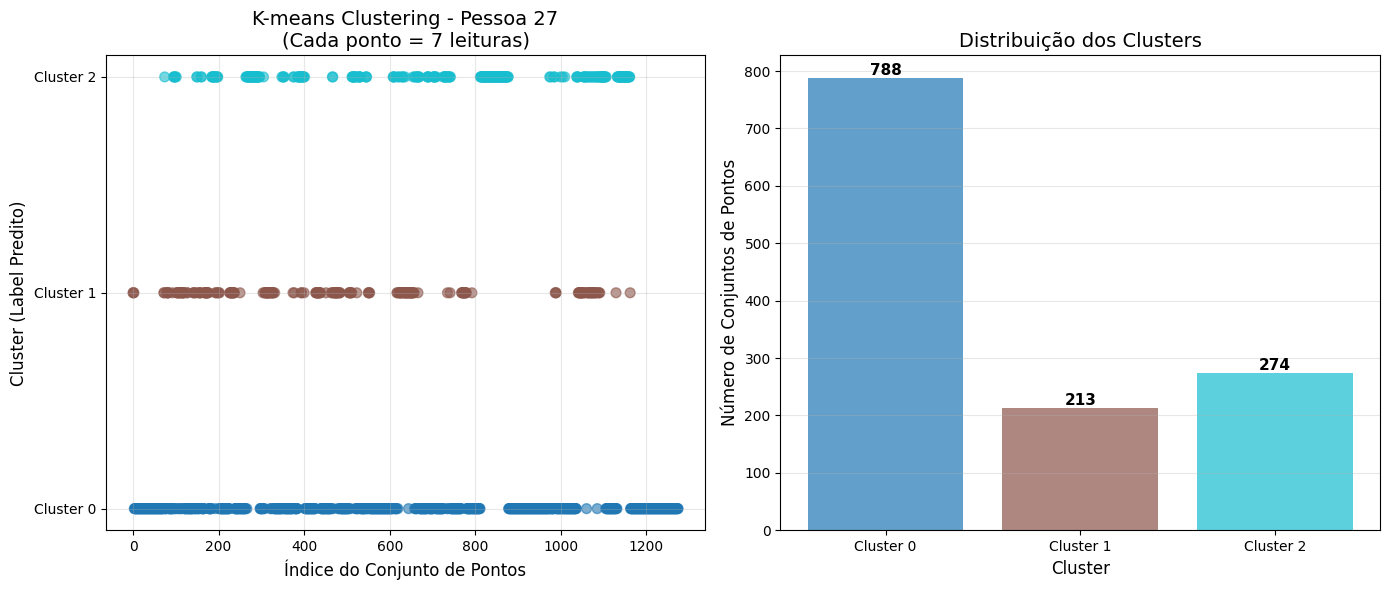


✓ Gráfico salvo como 'clustering_pessoa_27.png'

ESTATÍSTICAS
Cluster 0: 788 conjuntos (61.8%)
Cluster 1: 213 conjuntos (16.7%)
Cluster 2: 274 conjuntos (21.5%)

ANÁLISE - PESSOA 28

[1/6] Carregando dados...
   ✓ Acelerômetro: 7442 pontos
   ✓ Giroscópio: 7442 pontos

[2/6] Sincronizando dados (tolerância={TOLERANCIA_SINCRONIZACAO_S}s)...
   ✓ Dados sincronizados: 7442 pontos (taxa original)

[3/6] Usando dados sincronizados (sem chamar realizar_downsample)...
   ✓ Pontos usados: 7442 pontos

[4/6] Criando features (janelas de 7 pontos)...
   ✓ 1063 conjuntos de pontos criados
   ✓ Cada conjunto representa 7 * 1s

[5/6] Aplicando K-means (k=3)...
   ✓ Clustering concluído
   ✓ Inércia: 35263.05

[6/6] Gerando visualização...
   ✓ 1063 conjuntos de pontos criados
   ✓ Cada conjunto representa 7 * 1s

[5/6] Aplicando K-means (k=3)...
   ✓ Clustering concluído
   ✓ Inércia: 35263.05

[6/6] Gerando visualização...


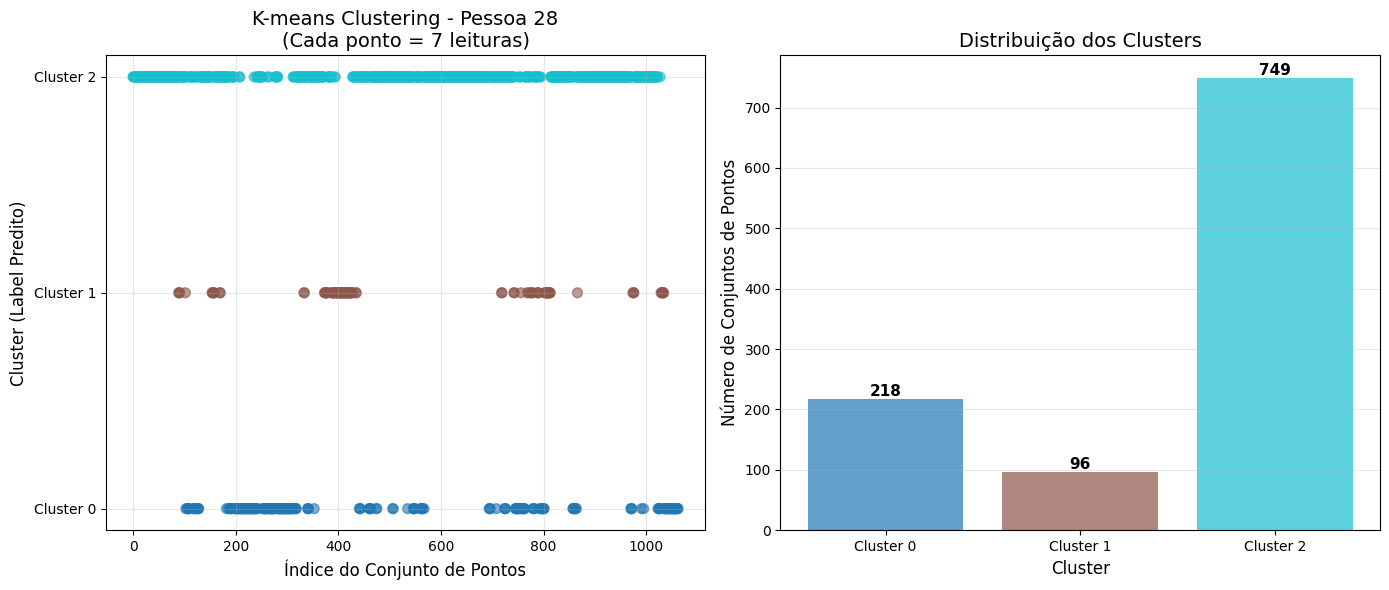


✓ Gráfico salvo como 'clustering_pessoa_28.png'

ESTATÍSTICAS
Cluster 0: 218 conjuntos (20.5%)
Cluster 1: 96 conjuntos (9.0%)
Cluster 2: 749 conjuntos (70.5%)

ANÁLISE - PESSOA 29

[1/6] Carregando dados...
   ✓ Acelerômetro: 7010 pontos
   ✓ Giroscópio: 7010 pontos

[2/6] Sincronizando dados (tolerância={TOLERANCIA_SINCRONIZACAO_S}s)...
   ✓ Dados sincronizados: 7010 pontos (taxa original)

[3/6] Usando dados sincronizados (sem chamar realizar_downsample)...
   ✓ Pontos usados: 7010 pontos

[4/6] Criando features (janelas de 7 pontos)...
   ✓ 1001 conjuntos de pontos criados
   ✓ Cada conjunto representa 7 * 1s

[5/6] Aplicando K-means (k=3)...
   ✓ Clustering concluído
   ✓ Inércia: 32477.85

[6/6] Gerando visualização...
   ✓ 1001 conjuntos de pontos criados
   ✓ Cada conjunto representa 7 * 1s

[5/6] Aplicando K-means (k=3)...
   ✓ Clustering concluído
   ✓ Inércia: 32477.85

[6/6] Gerando visualização...


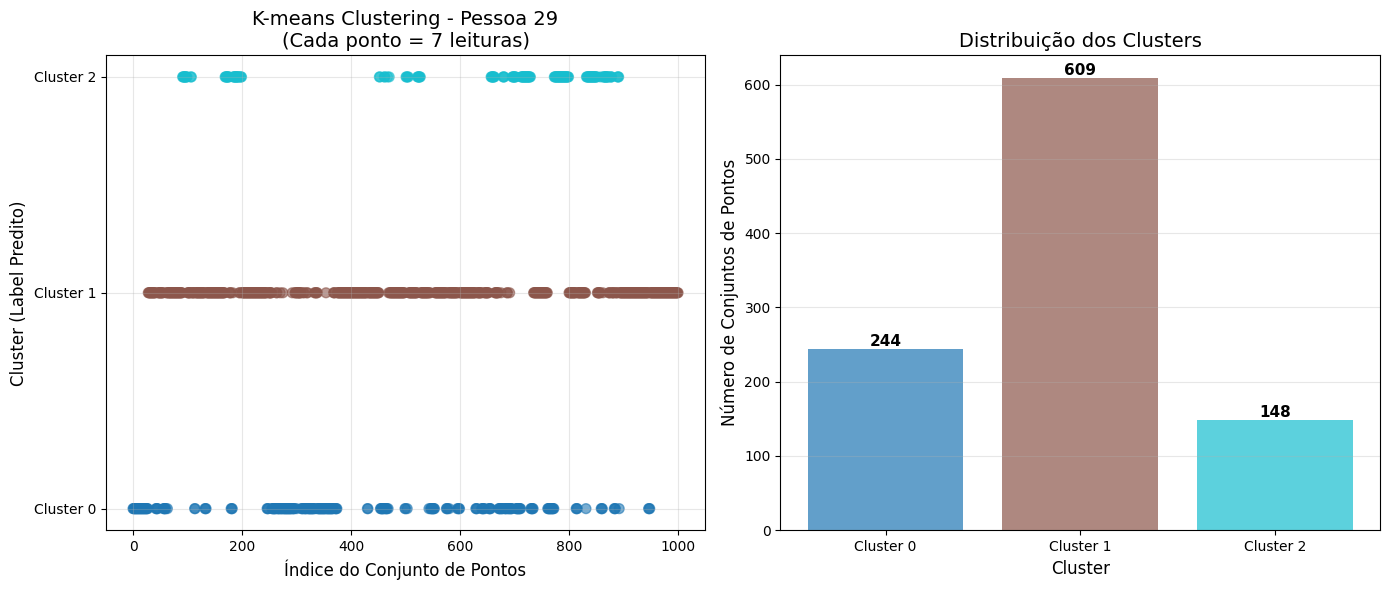


✓ Gráfico salvo como 'clustering_pessoa_29.png'

ESTATÍSTICAS
Cluster 0: 244 conjuntos (24.4%)
Cluster 1: 609 conjuntos (60.8%)
Cluster 2: 148 conjuntos (14.8%)

ANÁLISE - PESSOA 30

[1/6] Carregando dados...
   ✓ Acelerômetro: 8743 pontos
   ✓ Giroscópio: 8743 pontos

[2/6] Sincronizando dados (tolerância={TOLERANCIA_SINCRONIZACAO_S}s)...
   ✓ Dados sincronizados: 8743 pontos (taxa original)

[3/6] Usando dados sincronizados (sem chamar realizar_downsample)...
   ✓ Pontos usados: 8743 pontos

[4/6] Criando features (janelas de 7 pontos)...
   ✓ 1249 conjuntos de pontos criados
   ✓ Cada conjunto representa 7 * 1s

[5/6] Aplicando K-means (k=3)...
   ✓ Clustering concluído
   ✓ Inércia: 41198.63

[6/6] Gerando visualização...
   ✓ 1249 conjuntos de pontos criados
   ✓ Cada conjunto representa 7 * 1s

[5/6] Aplicando K-means (k=3)...
   ✓ Clustering concluído
   ✓ Inércia: 41198.63

[6/6] Gerando visualização...


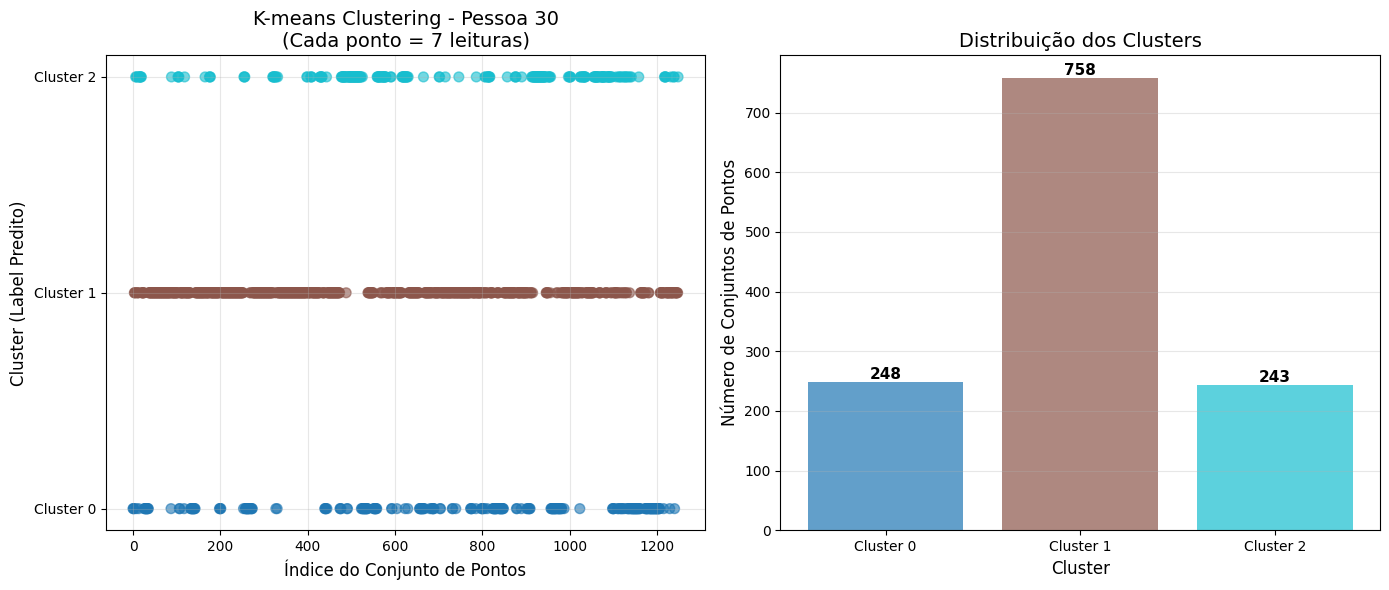


✓ Gráfico salvo como 'clustering_pessoa_30.png'

ESTATÍSTICAS
Cluster 0: 248 conjuntos (19.9%)
Cluster 1: 758 conjuntos (60.7%)
Cluster 2: 243 conjuntos (19.5%)

ANÁLISE - PESSOA 31

[1/6] Carregando dados...
   ✓ Acelerômetro: 7814 pontos
   ✓ Giroscópio: 7814 pontos

[2/6] Sincronizando dados (tolerância={TOLERANCIA_SINCRONIZACAO_S}s)...
   ✓ Dados sincronizados: 7814 pontos (taxa original)

[3/6] Usando dados sincronizados (sem chamar realizar_downsample)...
   ✓ Pontos usados: 7814 pontos

[4/6] Criando features (janelas de 7 pontos)...
   ✓ 1116 conjuntos de pontos criados
   ✓ Cada conjunto representa 7 * 1s

[5/6] Aplicando K-means (k=3)...
   ✓ Clustering concluído
   ✓ Inércia: 37368.84

[6/6] Gerando visualização...
   ✓ 1116 conjuntos de pontos criados
   ✓ Cada conjunto representa 7 * 1s

[5/6] Aplicando K-means (k=3)...
   ✓ Clustering concluído
   ✓ Inércia: 37368.84

[6/6] Gerando visualização...


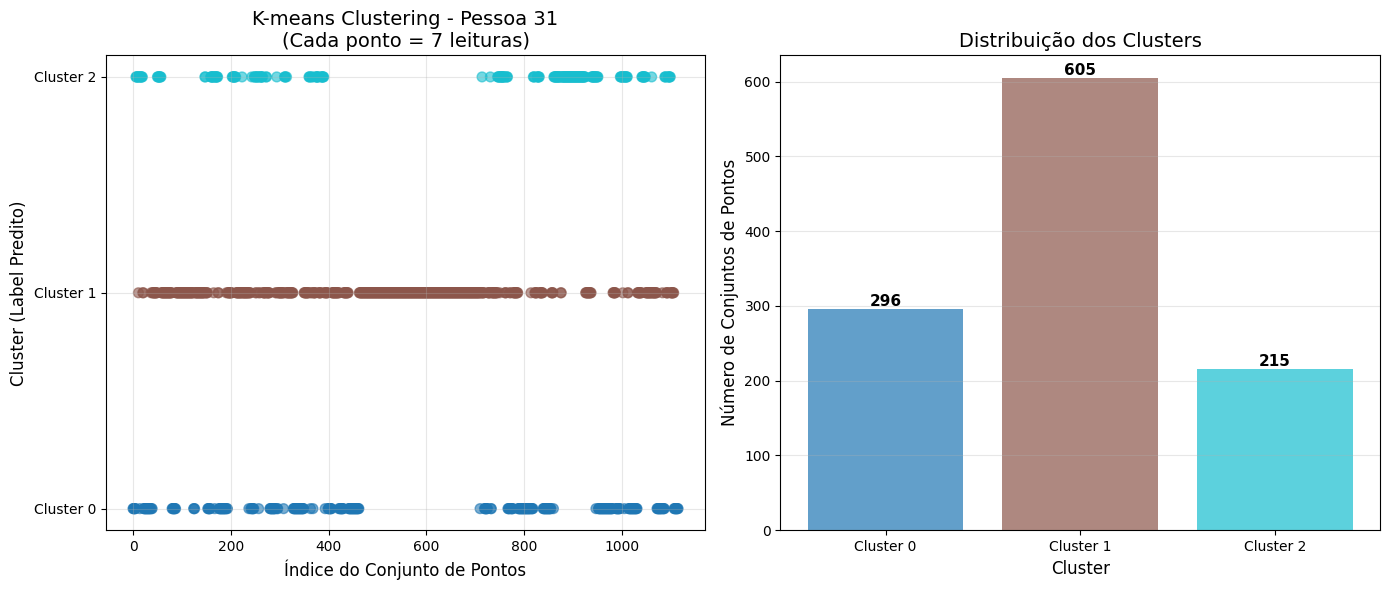


✓ Gráfico salvo como 'clustering_pessoa_31.png'

ESTATÍSTICAS
Cluster 0: 296 conjuntos (26.5%)
Cluster 1: 605 conjuntos (54.2%)
Cluster 2: 215 conjuntos (19.3%)

ANÁLISE - PESSOA 32

[1/6] Carregando dados...
   ✓ Acelerômetro: 9493 pontos
   ✓ Giroscópio: 9493 pontos

[2/6] Sincronizando dados (tolerância={TOLERANCIA_SINCRONIZACAO_S}s)...
   ✓ Dados sincronizados: 9493 pontos (taxa original)

[3/6] Usando dados sincronizados (sem chamar realizar_downsample)...
   ✓ Pontos usados: 9493 pontos

[4/6] Criando features (janelas de 7 pontos)...
   ✓ 1356 conjuntos de pontos criados
   ✓ Cada conjunto representa 7 * 1s

[5/6] Aplicando K-means (k=3)...
   ✓ Clustering concluído
   ✓ Inércia: 44345.74

[6/6] Gerando visualização...
   ✓ 1356 conjuntos de pontos criados
   ✓ Cada conjunto representa 7 * 1s

[5/6] Aplicando K-means (k=3)...
   ✓ Clustering concluído
   ✓ Inércia: 44345.74

[6/6] Gerando visualização...


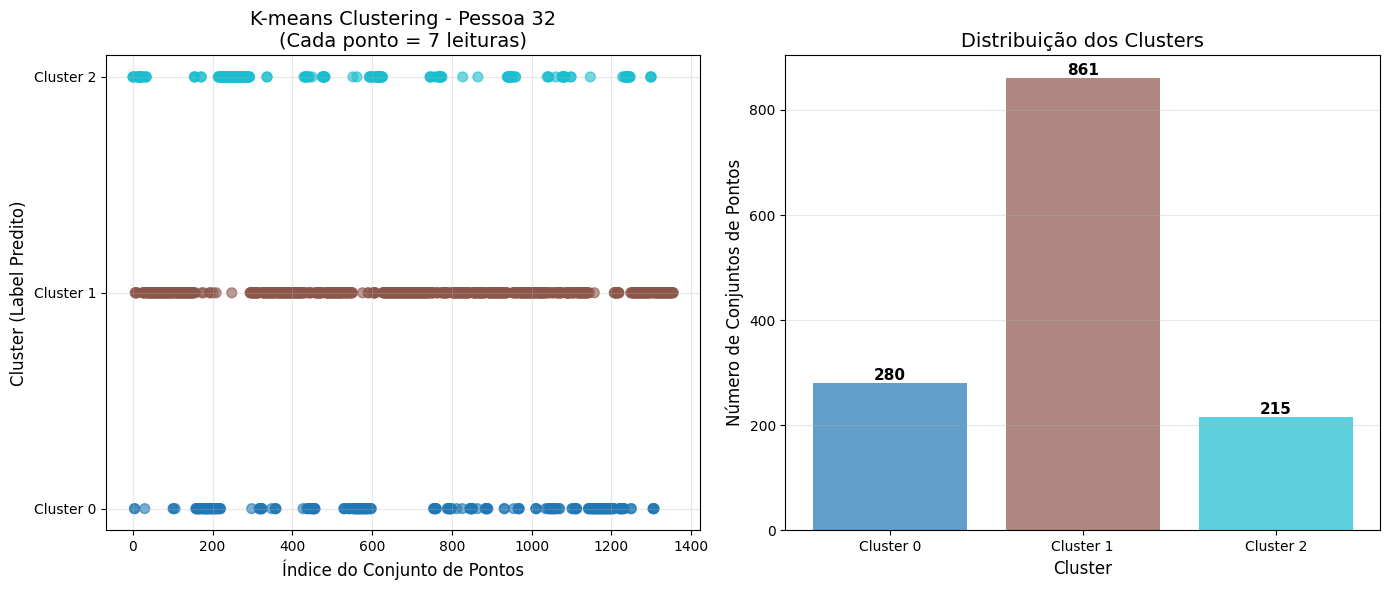


✓ Gráfico salvo como 'clustering_pessoa_32.png'

ESTATÍSTICAS
Cluster 0: 280 conjuntos (20.6%)
Cluster 1: 861 conjuntos (63.5%)
Cluster 2: 215 conjuntos (15.9%)

ANÁLISE - PESSOA 33

[1/6] Carregando dados...
   ✓ Acelerômetro: 7977 pontos
   ✓ Giroscópio: 7977 pontos

[2/6] Sincronizando dados (tolerância={TOLERANCIA_SINCRONIZACAO_S}s)...
   ✓ Dados sincronizados: 7977 pontos (taxa original)

[3/6] Usando dados sincronizados (sem chamar realizar_downsample)...
   ✓ Pontos usados: 7977 pontos

[4/6] Criando features (janelas de 7 pontos)...
   ✓ 1139 conjuntos de pontos criados
   ✓ Cada conjunto representa 7 * 1s

[5/6] Aplicando K-means (k=3)...
   ✓ Clustering concluído
   ✓ Inércia: 37679.98

[6/6] Gerando visualização...
   ✓ 1139 conjuntos de pontos criados
   ✓ Cada conjunto representa 7 * 1s

[5/6] Aplicando K-means (k=3)...
   ✓ Clustering concluído
   ✓ Inércia: 37679.98

[6/6] Gerando visualização...


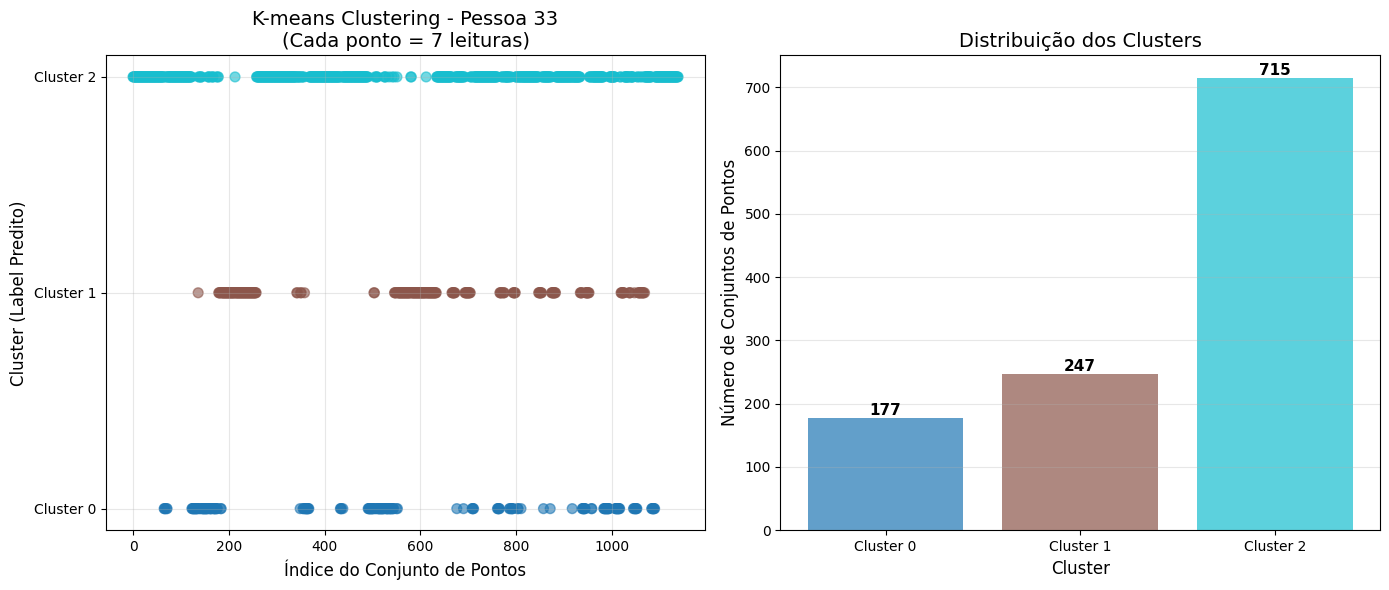


✓ Gráfico salvo como 'clustering_pessoa_33.png'

ESTATÍSTICAS
Cluster 0: 177 conjuntos (15.5%)
Cluster 1: 247 conjuntos (21.7%)
Cluster 2: 715 conjuntos (62.8%)

ANÁLISE - PESSOA 34

[1/6] Carregando dados...
   ✓ Acelerômetro: 7113 pontos
   ✓ Giroscópio: 7113 pontos

[2/6] Sincronizando dados (tolerância={TOLERANCIA_SINCRONIZACAO_S}s)...
   ✓ Dados sincronizados: 7113 pontos (taxa original)

[3/6] Usando dados sincronizados (sem chamar realizar_downsample)...
   ✓ Pontos usados: 7113 pontos

[4/6] Criando features (janelas de 7 pontos)...
   ✓ 1016 conjuntos de pontos criados
   ✓ Cada conjunto representa 7 * 1s

[5/6] Aplicando K-means (k=3)...
   ✓ Clustering concluído
   ✓ Inércia: 32714.15

[6/6] Gerando visualização...
   ✓ 1016 conjuntos de pontos criados
   ✓ Cada conjunto representa 7 * 1s

[5/6] Aplicando K-means (k=3)...
   ✓ Clustering concluído
   ✓ Inércia: 32714.15

[6/6] Gerando visualização...


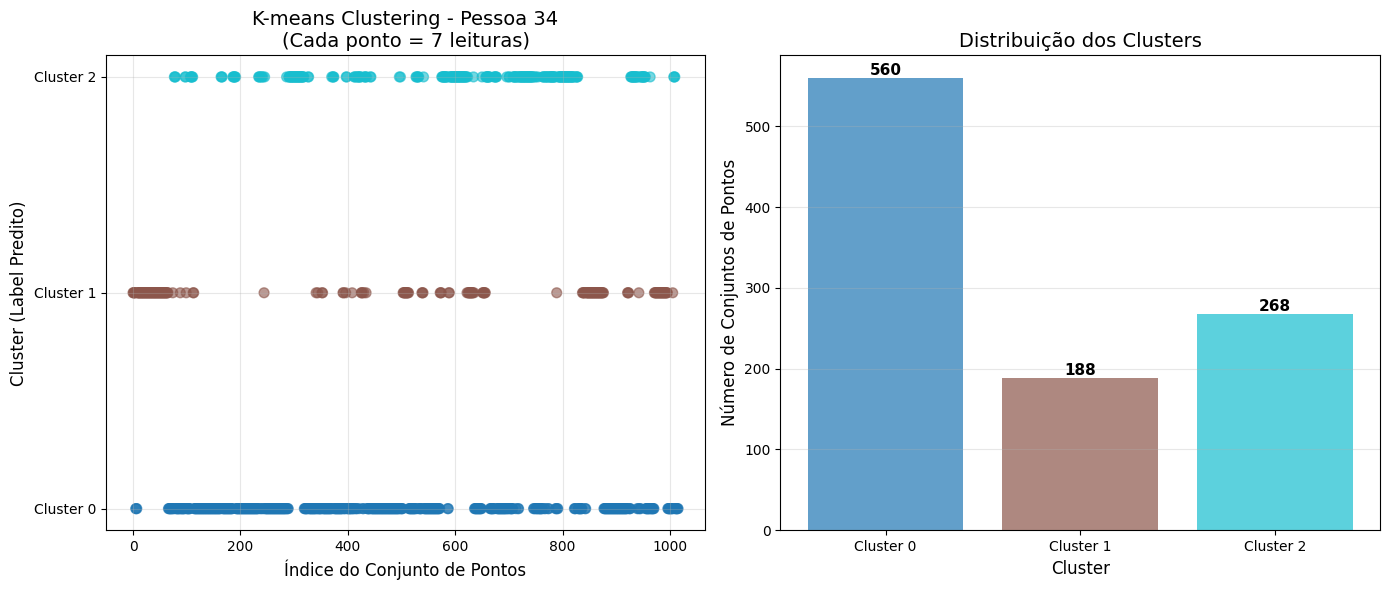


✓ Gráfico salvo como 'clustering_pessoa_34.png'

ESTATÍSTICAS
Cluster 0: 560 conjuntos (55.1%)
Cluster 1: 188 conjuntos (18.5%)
Cluster 2: 268 conjuntos (26.4%)

ANÁLISE - PESSOA 36

[1/6] Carregando dados...
   ✓ Acelerômetro: 7597 pontos
   ✓ Giroscópio: 7597 pontos

[2/6] Sincronizando dados (tolerância={TOLERANCIA_SINCRONIZACAO_S}s)...
   ✓ Dados sincronizados: 7597 pontos (taxa original)

[3/6] Usando dados sincronizados (sem chamar realizar_downsample)...
   ✓ Pontos usados: 7597 pontos

[4/6] Criando features (janelas de 7 pontos)...
   ✓ 1085 conjuntos de pontos criados
   ✓ Cada conjunto representa 7 * 1s

[5/6] Aplicando K-means (k=3)...
   ✓ Clustering concluído
   ✓ Inércia: 36211.21

[6/6] Gerando visualização...
   ✓ 1085 conjuntos de pontos criados
   ✓ Cada conjunto representa 7 * 1s

[5/6] Aplicando K-means (k=3)...
   ✓ Clustering concluído
   ✓ Inércia: 36211.21

[6/6] Gerando visualização...


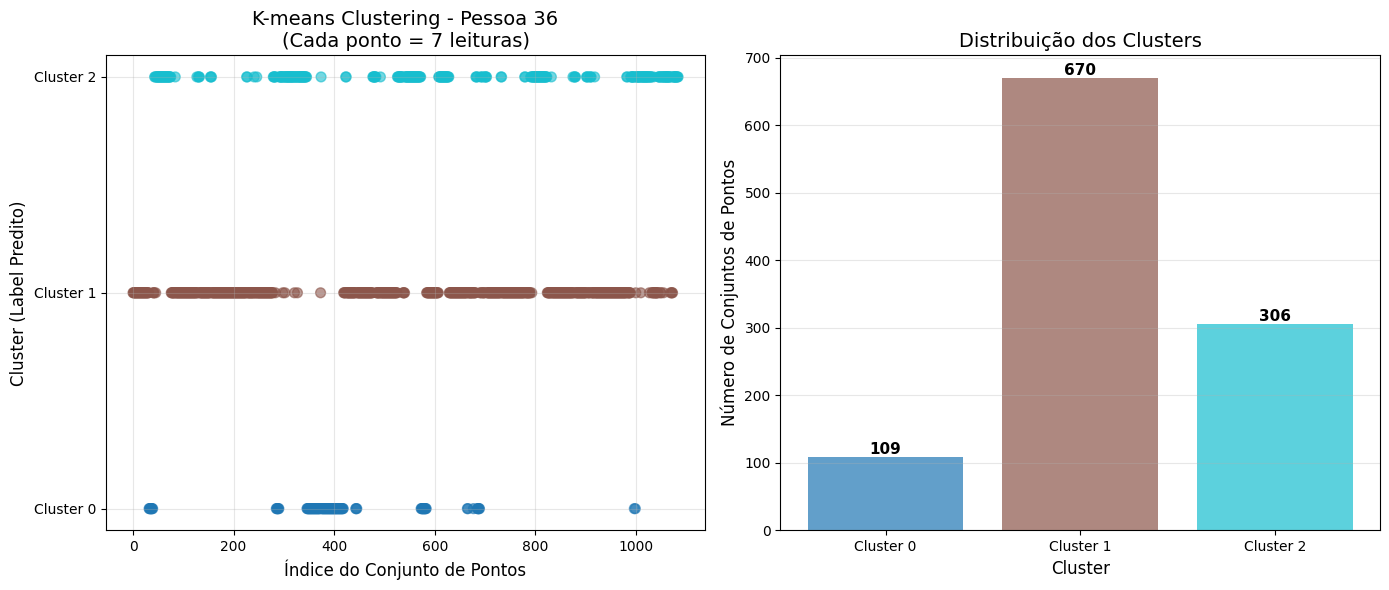


✓ Gráfico salvo como 'clustering_pessoa_36.png'

ESTATÍSTICAS
Cluster 0: 109 conjuntos (10.0%)
Cluster 1: 670 conjuntos (61.8%)
Cluster 2: 306 conjuntos (28.2%)

ANÁLISE - PESSOA 37

[1/6] Carregando dados...
   ✓ Acelerômetro: 9234 pontos
   ✓ Giroscópio: 9234 pontos

[2/6] Sincronizando dados (tolerância={TOLERANCIA_SINCRONIZACAO_S}s)...
   ✓ Dados sincronizados: 9234 pontos (taxa original)

[3/6] Usando dados sincronizados (sem chamar realizar_downsample)...
   ✓ Pontos usados: 9234 pontos

[4/6] Criando features (janelas de 7 pontos)...
   ✓ 1319 conjuntos de pontos criados
   ✓ Cada conjunto representa 7 * 1s

[5/6] Aplicando K-means (k=3)...
   ✓ Clustering concluído
   ✓ Inércia: 44246.55

[6/6] Gerando visualização...
   ✓ 1319 conjuntos de pontos criados
   ✓ Cada conjunto representa 7 * 1s

[5/6] Aplicando K-means (k=3)...
   ✓ Clustering concluído
   ✓ Inércia: 44246.55

[6/6] Gerando visualização...


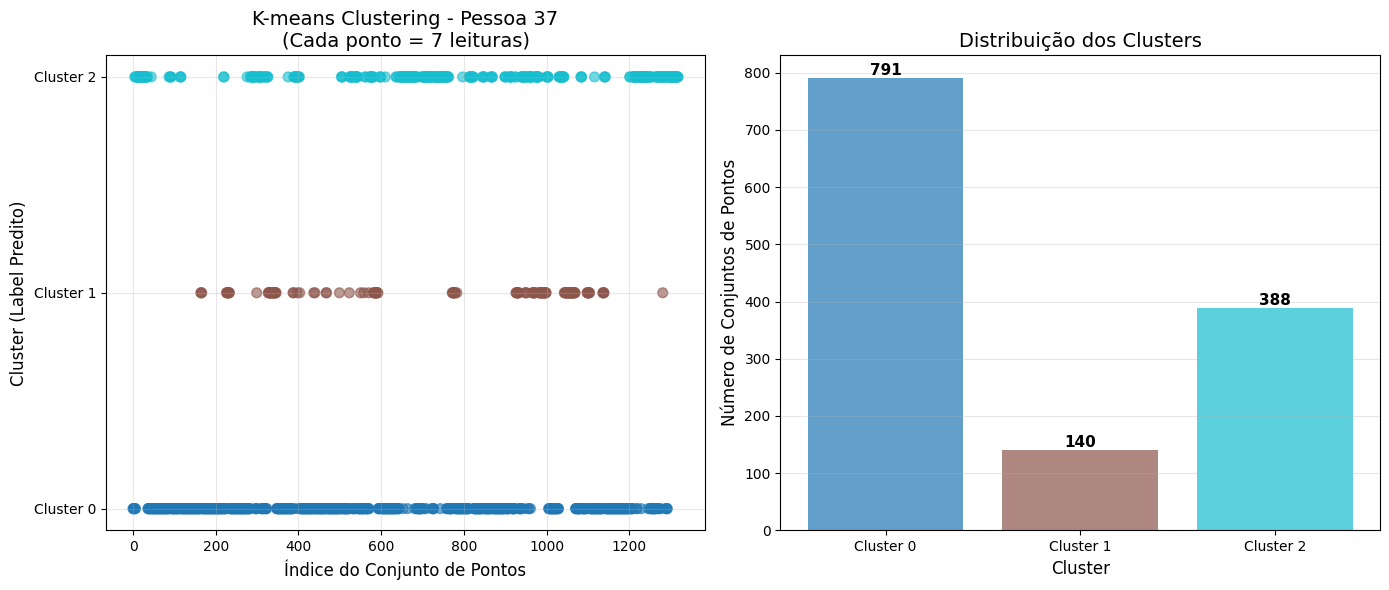


✓ Gráfico salvo como 'clustering_pessoa_37.png'

ESTATÍSTICAS
Cluster 0: 791 conjuntos (60.0%)
Cluster 1: 140 conjuntos (10.6%)
Cluster 2: 388 conjuntos (29.4%)

ANÁLISE - PESSOA 38

[1/6] Carregando dados...
   ✓ Acelerômetro: 10347 pontos
   ✓ Giroscópio: 10347 pontos

[2/6] Sincronizando dados (tolerância={TOLERANCIA_SINCRONIZACAO_S}s)...
   ✓ Dados sincronizados: 10347 pontos (taxa original)

[3/6] Usando dados sincronizados (sem chamar realizar_downsample)...
   ✓ Pontos usados: 10347 pontos

[4/6] Criando features (janelas de 7 pontos)...
   ✓ Acelerômetro: 10347 pontos
   ✓ Giroscópio: 10347 pontos

[2/6] Sincronizando dados (tolerância={TOLERANCIA_SINCRONIZACAO_S}s)...
   ✓ Dados sincronizados: 10347 pontos (taxa original)

[3/6] Usando dados sincronizados (sem chamar realizar_downsample)...
   ✓ Pontos usados: 10347 pontos

[4/6] Criando features (janelas de 7 pontos)...
   ✓ 1478 conjuntos de pontos criados
   ✓ Cada conjunto representa 7 * 1s

[5/6] Aplicando K-means (k=3).

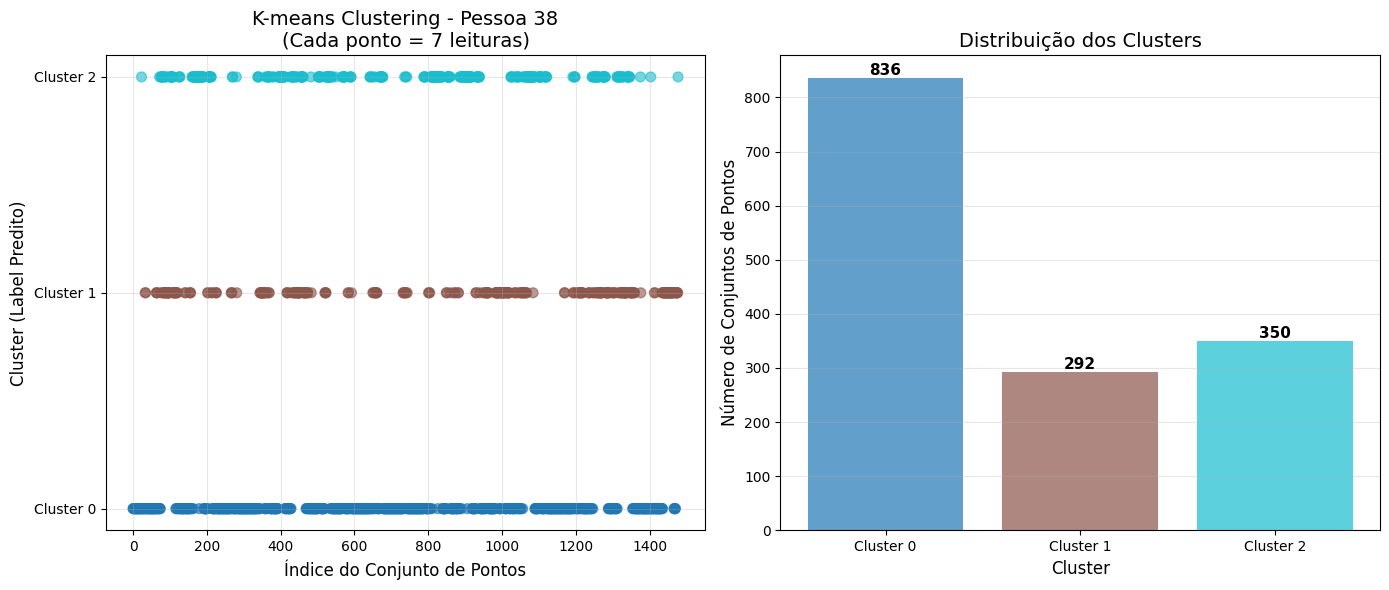


✓ Gráfico salvo como 'clustering_pessoa_38.png'

ESTATÍSTICAS
Cluster 0: 836 conjuntos (56.6%)
Cluster 1: 292 conjuntos (19.8%)
Cluster 2: 350 conjuntos (23.7%)


SUMÁRIO GERAL
Total de pessoas analisadas: 26/27

ANÁLISE CONCLUÍDA!

Para analisar todas as pessoas, descomente a última linha do script.


In [74]:
if __name__ == "__main__":
    print("\n" + "="*60)
    print("CLUSTERIZAÇÃO K-MEANS - ACELERÔMETRO E GIROSCÓPIO")
    print("="*60)
    print(f"Taxa de amostragem: {TOLERANCIA_SINCRONIZACAO_S}s")
    print(f"Número de clusters: {N_CLUSTERS}")
    print(f"Tamanho da janela: {WINDOW_SIZE} pontos (leituras por janela)")
    
    # Opção 1: Analisar apenas uma pessoa (recomendado para começar)
    print("\n" + "-"*60)
    print("Opção escolhida: Analisar uma pessoa primeiro")
    print("-"*60)
    
    df_combined, features, labels, kmeans = analisar_pessoa(
        PESSOA_INICIAL, 
        window_size=WINDOW_SIZE, 
        n_clusters=N_CLUSTERS
    )
    
    # Descomente a linha abaixo para analisar todas as pessoas
    resultados = analisar_todas_pessoas(window_size=WINDOW_SIZE, n_clusters=N_CLUSTERS)
    
    print("\n" + "="*60)
    print("ANÁLISE CONCLUÍDA!")
    print("="*60)
    print("\nPara analisar todas as pessoas, descomente a última linha do script.")